<a id=top></a> 

# Final Project
Botti Alessandro (3115589), 
Leoni Eugenio (3119306), 
Lorenzetti Simone (3118280), 
Monaci Flavia (3013292), 
Puschiasis Priamo (3118686).


 ### Data, preprocessing and annotation
 - 1.1 [The Data](#data)
 - 1.2 [Preprocessing](#preprocess)
 
 
 ### Research Questions
 - 2.1 [Research Questions](#q&a)
 
 
 ### LDA & W2V
 - 3.1 [LDA Topic Modeling](#lda)
     * [Coherence Score](#lda_coher)
     * [Training model](#lda_train)
     * [Visualization](#lda_tsne)
 - 3.2 [Word2Vec Embeddings](#w2v)
     * [Visualization](#w2v_res)
     * [Clustering](#w2v_clust)
   
   
 ### Classification
 - 4.1 [Classification](#class)
     * [Most frequent](#class_mf)
     * [Hulk](#class_hulk)
     * [Improving Logistic Classifier](#ffa) 
     * [Convolutional Neural Network & lengthy improvement](#cnn)
     * [Bootstrap significance](#bootstrap) 


<a id=data></a>
## 1.1 Data
For this project we decided to use a dataset containing 120000 news articles belonging to 4 topics (World, 
Sports, Business and Sci/Tech). In particular the dataset has 3 columns: the first is an integer number from 1 to 4 identifying the category of the article, the second is a string containing the title and the third column represents the text of the article itself. 

Even though out dataset was already devided into a train and test set with 120000 and 7600 observations respectively, we decided to merge them and devide them again into 3 parts, one for training, one for development and the last one for testing.

Note: need to have notebook + .csv in the same folder (or set up path)

In [1]:
# some imports and data loading
import time
import re
import os
import pandas as pd
import numpy as np


# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
%matplotlib inline

# litteraly importing seaborn to set a cooler grid (need to find out if there is similar for matplotlib)
import seaborn as sns
sns.set_style("darkgrid") 

from sklearn.manifold import TSNE # Dim reduction for plotting

#######################################################################################################################
# set here the number of cores to use throughout the notebook
# cores = 8

# # can otherwise run this 2 lines
import multiprocessing
cores = multiprocessing.cpu_count() - 1

#######################################################################################################################

# Test set
test = pd.read_csv("test.csv", header=None)
test.columns = ['Class','Title','Article']

# Train set
train = pd.read_csv("train.csv", header=None) 
train.columns = ['Class','Title','Article']

# Merging
full = pd.concat([train,test], axis=0).reset_index(drop=True)

print('Merged correctly :',len(full) == len(train) + len(test)) # chek if same length

full["Article"]

Merged correctly : True


0         Reuters - Short-sellers, Wall Street's dwindli...
1         Reuters - Private investment firm Carlyle Grou...
2         Reuters - Soaring crude prices plus worries\ab...
3         Reuters - Authorities have halted oil export\f...
4         AFP - Tearaway world oil prices, toppling reco...
                                ...                        
127595    Ukrainian presidential candidate Viktor Yushch...
127596    With the supply of attractive pitching options...
127597    Like Roger Clemens did almost exactly eight ye...
127598    SINGAPORE : Doctors in the United States have ...
127599    EBay plans to buy the apartment and home renta...
Name: Article, Length: 127600, dtype: object

In [2]:
print("Total empty cells: {}".format(sum(full.isna().sum()))) # how many are empty
print("\nHow many counts we have for each class: \n")
print(full.groupby(['Class']).count())# How many instances for each class

Total empty cells: 0

How many counts we have for each class: 

       Title  Article
Class                
1      31900    31900
2      31900    31900
3      31900    31900
4      31900    31900


As we can see, we have a total of 127600 observations, equelly distributed among the four classes, and no empty cells

We can also create a new column which combines the title and the text of the article.

In [3]:
# Some functions to enlarge the dataset and give info
# create a function that merges `title` and `description` (since it might be useful later)
def merge_text(df, column1 = 'Title', column2 = 'Article'):
    """
    merges `title` and `description` and addes a white space btw the two
    takes as input a dataframe with columns `title` and `description`
    so that it can be used with pd.apply()
    """
    
    # initiate the output
    output = ''
    
    # add the title string and the description string
    output = output + df[column1] + " " +  df[column2]
    
    return output

# add the name of each class to the df
classes = {1:'World',
           2:'Sports',
           3:'Business',
           4:'Sci/Tech'
          }

def classes_names(num):
    """
    converts integers to class label
    """
    return classes[num]

# create a function that count the number of tokens in a sentence
def count_tokens(text):
    """
    text is a datafram column
    returns the number of tokens in a sentence
    """
    return len(text.split())

In [4]:
# add the labels
full['Labels'] = full['Class'].apply(classes_names)
full.head()

,Class,Title,Article,Labels
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Business
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Business
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Business
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Business
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",Business


<a id=preprocess></a>
# 1.1 Preprocessing

For the first task involving the creation of a topic model using LDA we opted for a rahter aggressive preprocessing, keeping only the lemmas of the words which are strictly longer than 2 characters and removing all stop words. We decided to implement this preprocessing in order to obtain coherent topics during the implementation of LDA. 

In [5]:
# preprocessing imports and functions
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from nltk.stem import WordNetLemmatizer, SnowballStemmer

wnl = WordNetLemmatizer()
stemmer = SnowballStemmer('english')


#### Functions for preprocessing from different sources (kaggle etc) and modified a bit
## Pretty fast used like this ----- might be considered incorrect -- but like this they are so fast.. 

# Only lemmas or stems preprocessing.
# Stemming seems overkill, using lemmas is gentler
# Drops words shorter than 3 because if if was shorter than 4 we'd lose the 'new' in new_york as bigram
def preprocess(text, lemma = False):
    if lemma:
        result=[lemma_lemma(token) for token in simple_preprocess(text) if token not in STOPWORDS and len(token) > 2]

    else:
        result=[lemma_stem(token) for token in simple_preprocess(text) if token not in STOPWORDS and len(token) > 2]
            
    return result

# The preprocess uses this one or the next one
# lemmatize (verbs) first and stem later 
# [WordNetLemmatizer - Returns the input word unchanged if it cannot be found in WordNet]
def lemma_stem(text):
    return stemmer.stem(wnl.lemmatize(text, pos='v'))

#Just lemmatizing verbs and nouns (much much more complicated lemmatizing every POS with this WordNetLemmatizer)
def lemma_lemma(text):
    return wnl.lemmatize(wnl.lemmatize(text,pos='v')) 


# create a function to remove unwanted words
def rem_unwanted_words(lemmas, words_to_remove):
    return [[word for word in l if word not in words_to_remove] for l in lemmas]

# create a function that helps us save the lemmatized version of each article as a new column in the train dataset
def combine_lemmas(lemmas, words_to_remove):
    output = []
    
    # remove the unwanted words
    cleaned_list = rem_unwanted_words(lemmas, words_to_remove)
    
    for i in range(len(cleaned_list)):
        output.append(' '.join(cleaned_list[i]))
    
    return output

Using the functioned defined above we can now preprocess the articles. Moreover, having a look at the articles' texts, we noticed that many had `\\` in them so we decided to remove them as well.

In [6]:
# First we create a list with the articles and then clean it
articles = full.Article.tolist()
print("Number of articles before : {}".format(len(articles)))

# Preprocessing: Removes those '\\' appearing in the articles and passes the article to the 'preprocess' function (probably does it automatically in the gensim 'simple_preprocess')
articles_lemmas = [ preprocess(' '.join(article.split('\\')), lemma=True) for article in articles]
print("Number of articles after : {}".format(len(articles_lemmas)))

print("\n Raw: \n")
print(articles[:3])
print("\n Processed: \n")
print(articles_lemmas[:3]) # output

Number of articles before : 127600
Number of articles after : 127600

 Raw: 

["Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.', 'Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.']

 Processed: 

[['reuters', 'short', 'seller', 'wall', 'street', 'dwindle', 'band', 'ultra', 'cynic', 'see', 'green'], ['reuters', 'private', 'investment', 'firm', 'carlyle', 'group', 'reputation', 'make', 'time', 'occasionally', 'controversial', 'play', 'defense', 'industry', 'quietly', 'place', 'bet', 'market'], ['reuters', 'soar', 'crude', 'price', 'plus', 'worry', 'economy', 'outlook', 'earn', 'expect',

In [7]:
# Insert words to remove 
to_remove = ['reuters','com']

# add the cleaned articles to the dataframe
full['Article_clean'] = combine_lemmas(articles_lemmas, to_remove)
print(full['Article_clean'][:3]) 

0    short seller wall street dwindle band ultra cy...
1    private investment firm carlyle group reputati...
2    soar crude price plus worry economy outlook ea...
Name: Article_clean, dtype: object


In [8]:
# repeat the same process for the titles and the full texts
title_lemmas = [ preprocess(' '.join(title.split('\\')), lemma=True) for title in full.Title.tolist()]

# add them as new columns in the dataframe
full['Title_clean'] = combine_lemmas(title_lemmas, to_remove)
full['Full_Text'] = merge_text(full[['Title_clean','Article_clean']], column1 = 'Title_clean', column2 = 'Article_clean')

In [9]:
# imports for bigrams and types
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary

# does exactly what its name says
def add_common_bigrams(docs, min_c = 0.01):
    phrases = Phrases(docs, min_count = min_c) # minimum count 
    bigram = Phraser(phrases)
    return bigram[docs]

def corpus_and_dict(df, column_w_text, min_c = None):
    
    # if we give min_c, join bigrams
    if min_c:
        corpus = add_common_bigrams(df[column_w_text].apply(str.split).tolist() , min_c = min_c)  
    # else just extract the corpus 
    else:
        corpus = df[column_w_text].apply(str.split).tolist() 
        
    dictionary = Dictionary(corpus)
    return corpus, dictionary

In [10]:
#df = full[full["Class"] == 3] # if we want to see topics for this class
df = full.copy() # creating a copy makes it easier to play with it

# cut other stopwords for LDA
custom_stopwords =  ['yesterday', 'tomorrow','year',
                     'monday','thursday', 'wednesday','tuesday','friday',
                     'saturday', 'sunday', 'day', 'hour', 'time', 'today',
                     'tonight', 'reuters', 'com']
# remove stopwords from Article clean
df['Article_clean'] = combine_lemmas(articles_lemmas, custom_stopwords)

df.head(1)

,Class,Title,Article,Labels,Article_clean,Title_clean,Full_Text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Business,short seller wall street dwindle band ultra cy...,wall bear claw black,wall bear claw black short seller wall street ...


In [11]:
''' Extract corpus and Dictionary '''

column_w_text = "Article_clean" 
min_c = 0.01 # min freq. threshold to join bi-grams

dictionary_post = corpus_and_dict(df, column_w_text)[1] # just to get stats
# corpus and dict for articles
corpus, dictionary = corpus_and_dict(df, column_w_text, min_c) 
# full text
corpus_full_text   = corpus_and_dict(df, column_w_text, min_c)[0]

In [12]:
' STATS BEFORE '

# create a column with num tokens for each article and title
full['Article_tokens_before'] = full['Article'].apply(count_tokens)
full['Title_tokens_before'] = full['Title'].apply(count_tokens)

# find the total and average number of tokens per title before cleaning the data
title_tokens_before = sum(full['Title_tokens_before']) 
avg_token_title_before = round(full['Title_tokens_before'].mean(),2)
print('Before preprocessing there is an average of {} tokens per title'.format(avg_token_title_before))
# find the total number of tokens per title before cleaning the data


# find the total and average number of tokens per article before cleaning the data
article_tokens_before = sum(full['Article_tokens_before']) 
avg_token_article_before = round(full['Article_tokens_before'].mean(),2)
print('Before preprocessing there is an average of {} tokens per article'.format(avg_token_article_before))


dictionary_pre = corpus_and_dict(full, column_w_text = "Article")[1]
print(dictionary_pre, flush=True)

Before preprocessing there is an average of 6.78 tokens per title
Before preprocessing there is an average of 31.06 tokens per article
Dictionary(161065 unique tokens: ['-', 'Reuters', 'Short-sellers,', "Street's", 'Wall']...)


In [13]:
' STATS AFTER '

# create a column with num tokens for each article and title
full['Article_tokens_after'] = full['Article_clean'].apply(count_tokens)
full['Title_tokens_after'] = full['Title_clean'].apply(count_tokens)

# find the total and average number of tokens per title before cleaning the data
title_tokens_after = sum(full['Title_tokens_after']) 
avg_token_title_after = round(full['Title_tokens_after'].mean(),2)
print('After preprocessing there is an average of {} tokens per title'.format(avg_token_title_after))
# find the total number of tokens per title before cleaning the data


# find the total and average number of tokens per article before cleaning the data
article_tokens_after = sum(full['Article_tokens_after']) 
avg_token_article_after = round(full['Article_tokens_after'].mean(),2)
print('After preprocessing there is an average of {} tokens per article'.format(avg_token_article_after))
print(dictionary_post, flush=True)

After preprocessing there is an average of 4.9 tokens per title
After preprocessing there is an average of 18.12 tokens per article
Dictionary(45400 unique tokens: ['band', 'cynic', 'dwindle', 'green', 'see']...)


The average number of tokens in the titles decreased from 6.78 before preprocessing to 4.9 afterwards. Similarly, the average number of tokens in the article went from 31.06 before preprocessing to 18.12 afterwards

In [14]:
dict_values_before = {"Title Tokens":title_tokens_before,
                      "Article Tokens":article_tokens_before,
                      "Types":len(dictionary_pre)}

dict_values_after = {"Title Tokens":title_tokens_after,
                      "Article Tokens":article_tokens_after,
                      "Types":len(dictionary_post)}

C:\Users\cirib\anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


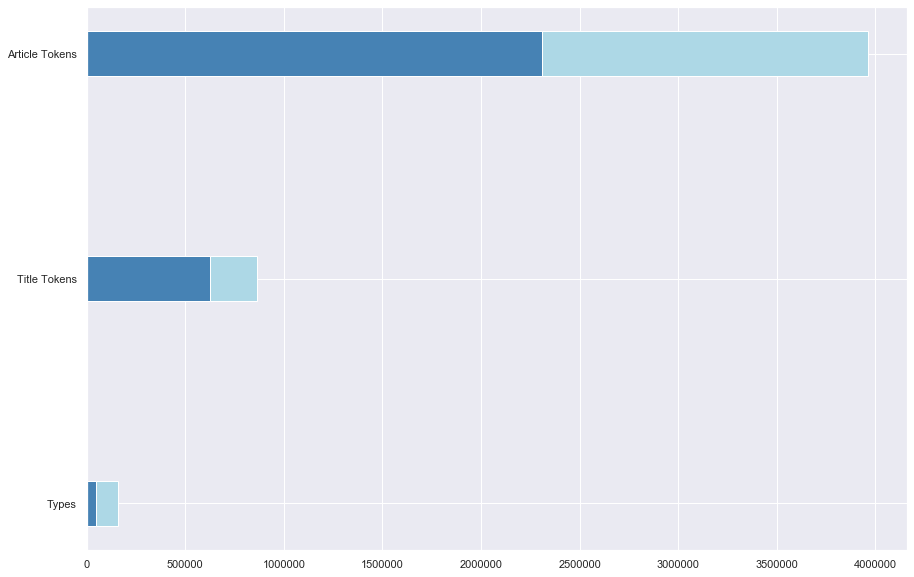

In [15]:
def plot(list_w_dict, col = 'green'):
    sns.set_context('notebook') # use large font
    plt.figure(figsize=(50, 10))
    
    dff = pd.DataFrame.from_dict(list_w_dict[0], orient = 'index').sort_values(by =0)
    descriptors = list(dff.columns.values)

    plt.subplot(131)
    plt.barh(dff.index.values, dff[descriptors][0].to_list(), color = col, height = 0.2)
    if len(list_w_dict) > 1:
        
        dff2 = pd.DataFrame.from_dict(list_w_dict[1], orient = 'index').sort_values(by =0)
        plt.subplot(131)
        plt.barh(dff2.index.values, dff2[descriptors][0].to_list(), color = 'steelblue', height = 0.2)
    plt.show()
    
plot([dict_values_before, dict_values_after], col = 'lightblue')

# the lightblue is the part that got cut after preprocessing

<a id=q&a></a>
## 2.1 Research questions 

Newspapers are the story tellers of our society. Studying them and being able to classify each into one specific category, based only on an extract from the article, can be a useful work, since it allows to support both journalism and media monitoring tasks. 
For this reason, we are going to try and classify extracts from news articles, into 4 categories:
- Tech;
- Sport;
- World; 
- Business. 

Since we have broad categories, which can easily cross each other (e.g. an article about an emerging Tech company has both Tech and Business components in it), we will check if LDA and clustering will correctly characterize our 4 topics, and whether they will actually identify more than 4.
Finally, we will try to see if, given the nature of our dataset, including titles improves classification, thus finding out if it is worth to extract that piece of information as well.

As for the SP part, we will face a NER task, comparing the performance of an improved Structured Perceptron against more recent NN methods
<a id=lda></a>
## 3.1 LDA

In [17]:
from gensim.models import TfidfModel, CoherenceModel, LdaMulticore

#Class for LDA
class Topic_Models(object):
    def __init__(self, corpus, no_below_val = 3, no_above_val = 0.1, dev_size = 10000, 
                 eval_size = 5000, num_topics_range = [2, 10], agg_by_cat = False):
                
        self.corpus = corpus
        self.dev_size = dev_size
        self.eval_size = eval_size
        self.num_topics_range = num_topics_range
        self.agg_by_cat = agg_by_cat
        self.no_above_val = no_above_val
        self.no_below_val = no_below_val
        
        self.instances = []
        self.dictionary = Dictionary(self.instances)
        self.ldacorpus = []
        self.tfidfmodel = TfidfModel(self.ldacorpus)
        
        self.coherence_values = []
    
    # This function serves the purpose of gathering all relevant ingredients for the
    # run function, that is: dictionary, instances, ldacorpus and model_corpus, 
    # which are returned.

    def prep_to_train(self, min_c = 0.01):
             
        print("\ncreating dictionary", flush=True)     
        # read in instances and create Dictionary object w information about frequencies etc. 
        self.dictionary = Dictionary(self.corpus)
        # get rid of words that are too rare or too frequent
        self.dictionary.filter_extremes(no_below= self.no_below_val, no_above= self.no_above_val)     
        print(self.dictionary, flush=True)

        #replace words by their numerical IDs and their frequency
        print("\ntranslating corpus to IDs", flush=True)      
        self.ldacorpus = [self.dictionary.doc2bow(text) for text in self.corpus]
        
        # learn TFIDF values from corpus
        print("tf-idf transformation", flush=True)    
        self.tfidfmodel = TfidfModel(self.ldacorpus)
        # transform raw frequencies into TFIDF    
        self.model_corpus = self.tfidfmodel[self.ldacorpus]
        print("\nReady for Training")
        
        return self.ldacorpus
         
    # creates coherence_values scores for a number of topics specified 
    # by num_topics_range
    def evaluator(self):
        
        model_list = []
        for num_topics in range(self.num_topics_range[0], self.num_topics_range[1]):
            model = LdaMulticore(corpus= self.model_corpus[:self.dev_size], id2word= self.dictionary, num_topics= num_topics)
            model_list.append(model)
            coherencemodel_umass = CoherenceModel(model=model, 
                                                  texts= self.corpus[self.dev_size : self.dev_size + self.eval_size], 
                                                  dictionary= self.dictionary, 
                                                  coherence='u_mass')

            coherencemodel_cv = CoherenceModel(model=model, 
                                               texts= self.corpus[self.dev_size : self.dev_size + self.eval_size], 
                                               dictionary= self.dictionary, 
                                               coherence='c_v')

            umass_score = coherencemodel_umass.get_coherence()
            cv_score = coherencemodel_cv.get_coherence()

            print(num_topics, umass_score, cv_score)
            self.coherence_values.append((num_topics, umass_score, cv_score))

        return self.coherence_values        
    
    def C_V_plot(self):
        
        st = self.num_topics_range[0]
        end = self.num_topics_range[1]
        %matplotlib inline
        #sns.set_context('poster') # use large font
        scores = pd.DataFrame(self.coherence_values, columns=['num_topics', 'UMass', 'CV'])
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
        scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(st,end));
        scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(st,end));
        
    
    # Fits the model and prints topics
    # if agg_by_cat == False, it stops after printing topics,
    # otherwise it also aggregates by reviewTime and calls the plot
    def run(self, num_topics = 15, num_words = 8, alpha_val = 0.5, agg_by_cat = False, random_state_val = None):

        # find chunksize to make about 200 updates
        num_passes = 10
        chunk_size = len(self.model_corpus) * num_passes/200
        
        if not random_state_val:
            random_state_val = np.random.RandomState()
        
        print("fitting model \n", flush=True)
        model = LdaMulticore(num_topics= num_topics, # number of topics
                             corpus= self.model_corpus, # what to train on 
                             id2word= self.dictionary, # mapping from IDs to words
                             workers= min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                             passes= num_passes, # make this many passes over data
                             chunksize= chunk_size, # update after this many instances
                             alpha= alpha_val,
                             random_state  = random_state_val
                            )
            
        topic_corpus = model[self.model_corpus]

        # get the topic descritions
        topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
        # extract a list of tuples with topic number and descriptors from the model
        model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                        model.print_topics(num_topics=num_topics, num_words=num_words)]

        descriptors = []
        for i, m in model_topics:
            print(i+1, ", ".join(m[:num_words]))
            descriptors.append(", ".join(m[:2]).replace('"', ''))

        if agg_by_cat == True:
            self.aggregate_by_cat(topic_corpus, descriptors)

        return topic_corpus, descriptors, model

In [18]:
dev = int(len(df)*0.15)
eva = int(len(df)*0.8) 
topic_range = [2, 12]
no_below = 150  # we have 25k obs per class, we want a word to be at least in 1% of these
no_above = 0.1

TM = Topic_Models(corpus,
                  num_topics_range = topic_range, 
                  dev_size = dev, 
                  eval_size = eva,
                  no_above_val = no_above,
                  no_below_val = no_below)

In [19]:
ldacorpus = TM.prep_to_train()


creating dictionary
Dictionary(1209 unique tokens: ['see', 'wall_street', 'controversial', 'defense', 'group']...)

translating corpus to IDs
tf-idf transformation

Ready for Training


<a id=lda_coher></a>
### Coherence scores

2 -4.503779095670068 0.19749486384044362
3 -4.367094934027556 0.14921376626058794
4 -4.449848788365026 0.12479629574994155
5 -4.636989961285113 0.14265654463851624
6 -4.645498121093184 0.12787414341800882
7 -4.39023971364602 0.14758920907725442
8 -4.7397895684712905 0.1290826429269082
9 -4.548719108070346 0.13597112968600647
10 -4.61920621058667 0.14291532309985883
11 -4.482426060974013 0.1268110106356434

Done in : 2 min


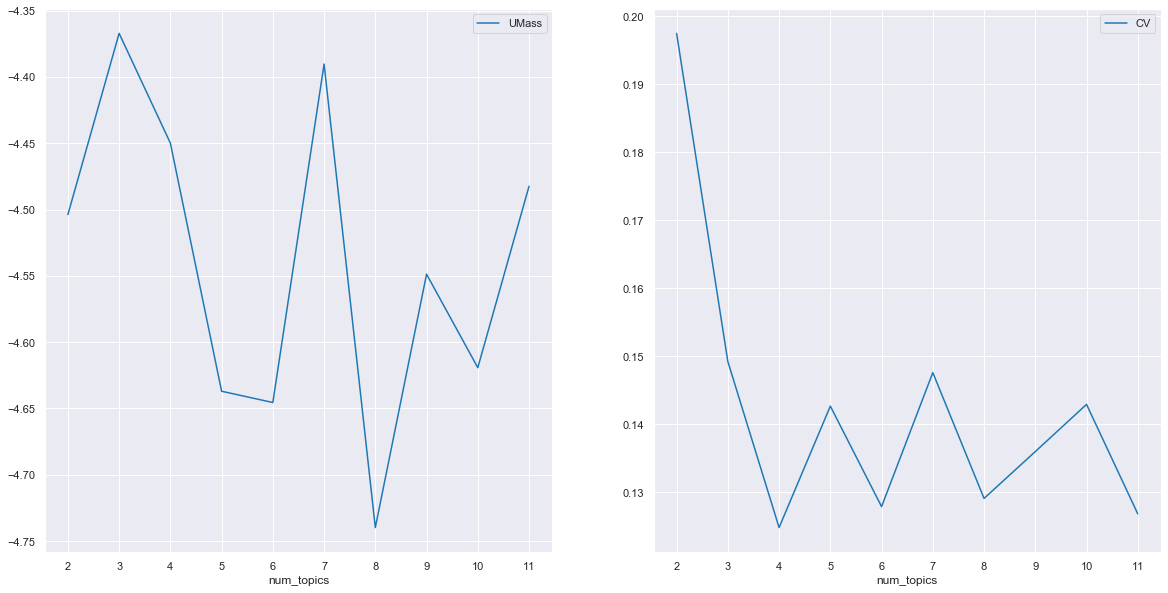

In [20]:
t0=time.time()

TM.evaluator()
TM.C_V_plot()

print('\nDone in : {} min'.format(round((time.time()-t0)/60)))

<a id=lda_train></a>
Cv isn't telling us anything useful, while umass suggests 3 or 7 topics.

For the first train, we will choose 4, as we know that there are 4 macro topics in our data, and we want to see if LDA manages to capture them correctly, then we will see what topics get blended together when using 7
### LDA train

In [21]:
k = 4  #number of topics
n = 20 #muber of passes over the data
num_words = 8 # num of words to display
random_state_val = 100
alpha = 0.5

topic_corpus, descriptors, lda_model = TM.run( num_topics = k, 
                                               alpha_val = alpha, 
                                               random_state_val = random_state_val,
                                               num_words = num_words)

fitting model 

1 "quot", "country", "win", "state", "iraq", "afp", "kill", "leave"
2 "company", "new", "service", "announce", "microsoft", "plan", "software", "people"
3 "game", "night", "season", "team", "player", "million", "come", "world"
4 "report", "new_york", "price", "stock", "share", "rise", "market", "accord"


It seems to have identified well our macro topics:
- 1 -> World
- 2 -> Sci-tech
- 3 -> Sport
- 4 -> Business



<a id=lda_tsne></a>
### t-SNE visualization

Done in : 0 min


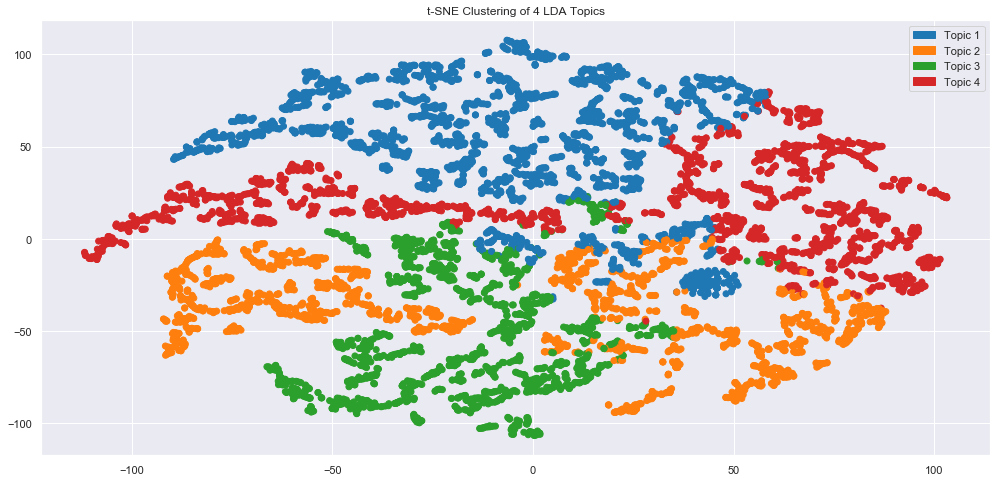

In [22]:
"""t-SNE transformation of LDA model results for PLOTTING"""
# [plot always comes out nice, but different each time --> randomness in fit_transform of TSNE]

t0=time.time() # ~2 min

k=4
n = 10000 #docs to use for plots

# Get topic weights and make array
topic_weights = []
for i, row_list in enumerate(lda_model[ldacorpus][:n]): #only the first 10k elements of the corpus (to run/plot faster) [!UNSURE!]
    topic_weights.append([w for i, w in row_list])    
arr = pd.DataFrame(topic_weights).fillna(0).values

topic_num_lda = np.argmax(arr, axis=1)# Dominant topic number in each doc

tsne_lda= TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(arr)# tSNE Dimension Reduction and fitting

#Plotting the t-SNE results

mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
fig, ax = plt.subplots(figsize=(17,8))

ax.set_title("t-SNE Clustering of {} LDA Topics".format(k))
ax.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num_lda] )
ax.legend(handles=[Patch(color=mycolors[i], label='Topic {}'.format(i+1)) for i in range(k)])

print('Done in : {} min'.format(round((time.time()-t0)/60)))

plt.show('notebook')

# topic 1 ('world') seems to be the one to intersecate with others the most

### Other LDa

In [ ]:
''' we didn't have time to re-run these cells''' 
k = 6  # suggested by umass
n = 30 
num_words = 8 
random_state_val = 100
alpha = 0.01

topic_corpus, descriptors, lda_model = TM.run( num_topics = k, 
                                               alpha_val = alpha, 
                                               random_state_val = random_state_val,
                                               num_words = num_words)

# topic 5 seems to be a blend of business and tech
# topic 3 is a blend of all, with 'world' dominating

In [ ]:
''' Here we used both articles and titles to characterize topics'''
dev = int(len(df)*0.15)
eva = int(len(df)*0.8) 
topic_range = [2, 12]
no_below = 80 
no_above = 0.08

TM = Topic_Models(corpus_full_text,
                  num_topics_range = topic_range, 
                  dev_size = dev, 
                  eval_size = eva,
                  no_above_val = no_above,
                  no_below_val = no_below)

ldacorpus = TM.prep_to_train()
TM.evaluator()
TM.C_V_plot()

In [ ]:
k = 4  # suggested by CV
n = 30 
num_words = 8 
random_state_val = 100
alpha = 0.01

topic_corpus, descriptors, lda_model = TM.run( num_topics = k, 
                                               alpha_val = alpha, 
                                               random_state_val = random_state_val,
                                               num_words = num_words)

# topic 5 seems to be a blend of business and tech
# topic 3 is a blend of all, with 'world' dominating

In [ ]:
''' Here we run the CV plot using almost all data in the dev set 
It's kinda not the purposee of having a dev set, but we were curios
to see if 4 would came out '''

# We want to see if it goes close to identifying 4 topics

dev = int(len(df)*0.95)
eva = int(len(df)*0.5) 
topic_range = [2, 12]
no_below = 150
no_above = 0.1

TM = Topic_Models(corpus,
                  num_topics_range = topic_range, 
                  dev_size = dev, 
                  eval_size = eva,
                  no_above_val = no_above,
                  no_below_val = no_below)
ldacorpus = TM.prep_to_train()
TM.evaluator()
TM.C_V_plot()

'''Using the whole dataset to evaluate the best number of topics, we can see 
that 4 is the optimal number suggested by CV, together with 8,
while, according, to UMass, it yields only a slight improvement than choosing 3.
While this isnn't consistent across runs, CV usually suggestes 3 or 4 topics'''

<a id=w2v></a>
# Word2vec

We have opted for word2vec instead of doc2vec as we aren't really interested in what words are closer to what documents/topics. Indeed, the only way of obtaining relevant information using doc2vec would probably be to merge the articles extracts we have, based on the topic class the belong to. In this way, we could see their relative distance, or gete context words based on the document. Still, it doesn't sound that appealing, aslo because we can somewhat get this information with other methods, so we would rather look at what the words in this dataset will tell us by themselves

In [23]:
# word2vec import
from gensim.models import Word2Vec

In [24]:
# remember we created the corpus like this
# lemmas_less = full['Article_clean'].apply(str.split).tolist()
# corpus = add_common_bigrams(lemmas_less)

In [25]:
# Reproducibility, still doesn't reproduce 100%
import random
random.seed(200)
%env PYTHONHASHSEED 15

env: PYTHONHASHSEED=15


In [26]:
#instance of word embedder 
w2v_model = Word2Vec(seed=200, 
                     min_count=20,
                     window=5,
                     size=300,    #magic number right?
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores)

#building the vocabulary (~20/30 sec)
w2v_model.build_vocab(corpus)

In [27]:
"""Training the model (higher epochs, better model)"""
# ~1.45 min
%time w2v_model.train(corpus, total_examples=w2v_model.corpus_count, epochs=10)  

w2v_model.init_sims(replace=True) #free up memory

Wall time: 44.4 s


<a id=w2v_res></a>
### Exploring w2v results


In [28]:
# Most similar to queried word
w2v_model.wv.most_similar(positive=["iraq"]) 

[('iraqi', 0.9276266098022461),
 ('british_troop', 0.8962599039077759),
 ('aid_worker', 0.8890694379806519),
 ('take_hostage', 0.8833919763565063),
 ('hold_hostage', 0.8824170827865601),
 ('french_journalist', 0.8815522193908691),
 ('italian_woman', 0.874634861946106),
 ('margaret_hassan', 0.8731472492218018),
 ('lead_invasion', 0.866072416305542),
 ('kidnapper', 0.8638374209403992)]

In [29]:
# Most similar to queried word
w2v_model.wv.most_similar(positive=["wall_street"]) 

[('nasdaq', 0.9230697751045227),
 ('stock', 0.9191499948501587),
 ('higher', 0.9189749360084534),
 ('cnn_money', 0.9186731576919556),
 ('morgan_stanley', 0.9129493236541748),
 ('sharp_drop', 0.9101496338844299),
 ('slightly_higher', 0.90343177318573),
 ('early_trade', 0.9031907320022583),
 ('sharply_higher', 0.9026163816452026),
 ('better_expect', 0.8996278047561646)]

In [30]:
w2v_model.wv.most_similar(positive=["pretty"]) 

[('christmas_tree', 0.9755938053131104),
 ('wire_magazine', 0.9740283489227295),
 ('column', 0.9672972559928894),
 ('floor', 0.9667652249336243),
 ('door', 0.9630261659622192),
 ('piece', 0.9617211818695068),
 ('weight', 0.958128809928894),
 ('good_reason', 0.9562524557113647),
 ('sense', 0.956159770488739),
 ('brain', 0.9551014304161072)]

In [31]:
#how similar two words are (need to use the exact word - stems were horrible)
w2v_model.wv.similarity('technology', 'microsoft') # nice

0.68197685

In [32]:
# Which is the odd one out 
w2v_model.wv.doesnt_match(['money', 'stock', 'market', 'wall_street']) # tricky but correct

C:\Users\cirib\anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'money'

In [33]:
w2v_model.wv.doesnt_match(['event', 'dolphin', 'nfl', 'football']) # 'dolphins' are an american football team (lemmatized to dolphin)

'event'

In [34]:
# Word operations (e.g king-man+woman=queen) 

# Can't really think of something cool  [chenges across runs and should result in a country] 
w2v_model.wv.most_similar(positive=["unite_state", "weapon"], negative=["oil"], topn=5) # looool USA-oil+weapon=Nuclear [HELP]

[('north_korea', 0.7960764169692993),
 ('nuclear_experiment', 0.7926070094108582),
 ('seoul_south', 0.7920550107955933),
 ('moo_hyun', 0.7918910980224609),
 ('seoul_north', 0.7888392210006714)]

In [35]:
"""Plots the results from t-SNE dimensionality reduction of a focus word (in yellow),
its list of most similar (in blue) and opposite words (in red)."""

def visualplot(model, word):
    
    arrays = np.empty((0, 300), dtype='f') #300 dimension embedded
    word_labels = [word]   #initialize the list here with the focus word
    color_list  = ['yellow']  #initialize color list here

    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0) # adds the vector of the query word
    
    # gets list of most similar words and adds them to the array
    close_words = model.wv.most_similar([word]) 
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')  
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    #get list of opposite words and adds them to the array
    opposite_words = w2v_model.wv.most_similar(negative=[word]) 
    for wrd_score in opposite_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('red')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # t-SNE reduction
    np.set_printoptions(suppress=True) 
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(arrays)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]], 'y': [y for y in Y[:, 1]], 'words': word_labels, 'color': color_list})
    
    fig, ax = plt.subplots(figsize=(10,10))    
    ax.scatter(x=df["x"], y=df["y"], marker="o", c=df["color"])   # Basic plot 
    for row in range(0, df.shape[0]):
        ax.text(df["x"][row],df["y"][row],df["words"][row]).set_size(15) #notation for each point
    
    ax.set_title("t-SNE visualization for '{}'".format(word))

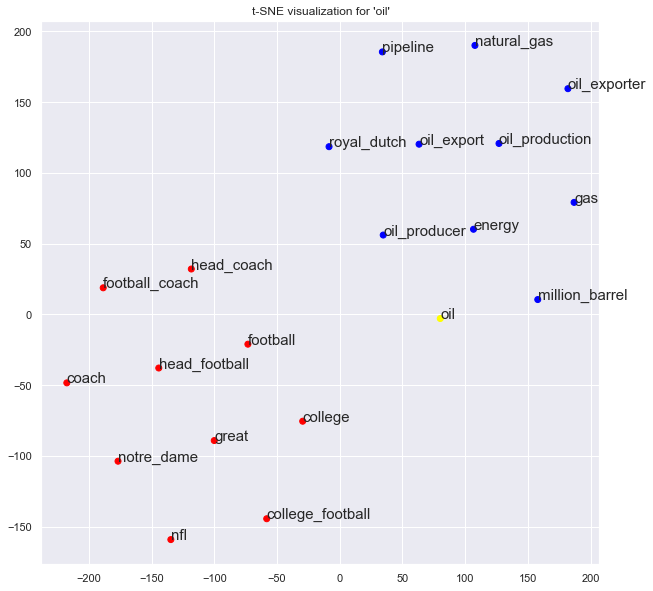

In [36]:
visualplot(w2v_model, 'oil') 

<a id=w2v_clust></a>
### Clustering 

In [38]:
#Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [39]:
#Extracting the word vectors from w2v model
w2v_vectors=w2v_model.wv.vectors

Fitted 5 clusters
Fitted 10 clusters
Fitted 15 clusters
Fitted 20 clusters
Fitted 25 clusters
Fitted 30 clusters
Time taken: 77.781


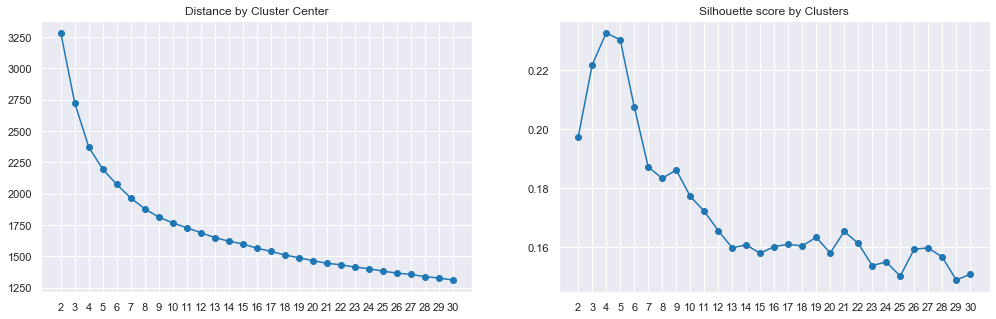

In [40]:
# Computing silhouette score and intercluster distance to chek how many clusters should be done
t=time.time()
k_range= range(2, 31)  #which k to check
dist = []
s_score = []
for k in k_range:
    kmean = KMeans(n_clusters=k, n_jobs=cores, random_state=0)
    dist.append(kmean.fit(w2v_vectors).inertia_)         #Squared mean intercluster distance 
    s_score.append(silhouette_score(w2v_vectors, kmean.fit_predict(w2v_vectors))) #silhouette score
    if (k%5==0):
        print('Fitted {} clusters'.format(k))  #feedback to get a sense of the advancement
      
print("Time taken: {}".format(round(time.time()-t,3)))

#Plot
f, ax = plt.subplots(1,2,figsize=(17,5))
ax[0].set_title('Distance by Cluster Center')
ax[0].set_xticks(k_range)
ax[0].set_xticklabels(k_range)
ax[0].plot(k_range, dist, marker='o')

ax[1].set_title('Silhouette score by Clusters')
ax[1].set_xticks(k_range)
ax[1].set_xticklabels(k_range)
ax[1].plot(k_range, s_score, marker='o')


plt.show()

Silhouette score shows a clearly that 4-5 is the best number of clusters. Since we have 4 classes, this comes as a relief, we'll cluster with k=4

In [41]:
# Setting k, clustering and setting indices
k=4
clust = KMeans(n_clusters = k).fit_predict(w2v_vectors)
index = list(clust)

#Extracting vocab list and creating a dictionaty-> word : the cluster where the word belongs.
voca_list = w2v_model.wv.index2word

voca_cluster = {voca_list[i]: index[i] for i in range(len(voca_list))}

In [42]:
#Extracting cluster words
def extract_words(voca_cluster, index, n_clusters, n_words):
    for cluster in range(n_clusters):
        word = []
        for i in range(len(voca_cluster.values())):# Iterate over the number of total words. 
            if(list(voca_cluster.values())[i] == cluster): #if correspondence append list
                word.append(list(voca_cluster.keys())[i])
        print("Cluster {} :".format(cluster+1)+', '.join(word[:n_words]))

In [43]:
extract_words(voca_cluster,index,k,n_words=10)

Cluster 1 :win, game, lead, team, night, end, season, open, run, start
Cluster 2 :week, government, country, state, unite_state, official, iraq, people, hold, american
Cluster 3 :new, company, quot, plan, world, announce, service, business, technology, release
Cluster 4 :say, new_york, report, month, million, group, market, price, help, expect


They look almost identical to the LDA topics.

Wall time: 6.91 s


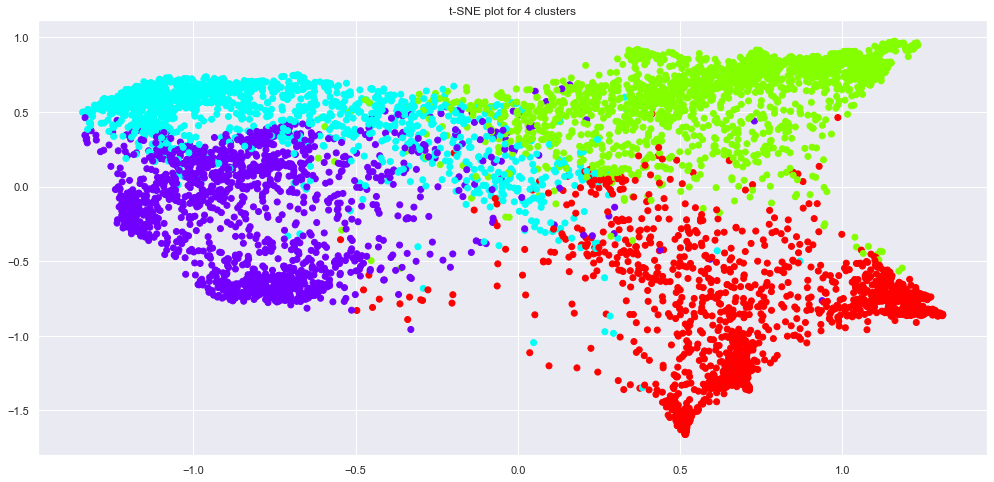

In [44]:
# t-sne is crazy slow on bocconi server don't know why, run it and it should be similar to the one below
"""t-SNE visualization of created clusters"""
import matplotlib.cm as cm # for colors

%time tsne = TSNE(n_components=2, random_state=0, n_jobs=8, n_iter=250, n_iter_without_progress = 50 ).fit_transform(w2v_vectors) #fit and transform

clust_col = [cm.hsv(i/(k)) for i in clust] #setting colors for both Ks 

#Plot
f, ax = plt.subplots(figsize=(17,8))
ax.set_title('t-SNE plot for {} clusters'.format(k))
ax.scatter(tsne[:, 0], tsne[:, 1], c=clust_col)

plt.show()

There is clear separation among clusters with only some units mixing

 <a id=class></a>
 # 4.1 Classification
 
Now that we are done with the first part, we will divide the daset in trainig-development-test sets in an 80:10:10 fashion given our large corpus.

In [45]:
full.head()

,Class,Title,Article,Labels,Article_clean,Title_clean,Full_Text,Article_tokens_before,Title_tokens_before,Article_tokens_after,Title_tokens_after
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Business,short seller wall street dwindle band ultra cy...,wall bear claw black,wall bear claw black short seller wall street ...,12,9,10,4
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Business,private investment firm carlyle group reputati...,carlyle look commercial aerospace,carlyle look commercial aerospace private inve...,30,6,17,4
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Business,soar crude price plus worry economy outlook ea...,oil economy cloud stock outlook,oil economy cloud stock outlook soar crude pri...,29,7,16,5
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Business,authority halt oil export flow main pipeline s...,iraq halt oil export main southern pipeline,iraq halt oil export main southern pipeline au...,27,9,19,7
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",Business,afp tearaway world oil price topple record str...,oil price soar time record pose new menace eco...,oil price soar time record pose new menace eco...,24,13,17,10


In [46]:
# Creating df with only response columne and cleaned article 
# (baseline and models need to work on the same data to be comparable)
data = full[['Class','Article_clean','Full_Text']]
data

,Class,Article_clean,Full_Text
0,3,short seller wall street dwindle band ultra cy...,wall bear claw black short seller wall street ...
1,3,private investment firm carlyle group reputati...,carlyle look commercial aerospace private inve...
2,3,soar crude price plus worry economy outlook ea...,oil economy cloud stock outlook soar crude pri...
3,3,authority halt oil export flow main pipeline s...,iraq halt oil export main southern pipeline au...
4,3,afp tearaway world oil price topple record str...,oil price soar time record pose new menace eco...
...,...,...,...
127595,1,ukrainian presidential candidate viktor yushch...,world ukrainian presidential candidate viktor ...
127596,2,supply attractive pitch option dwindle daily l...,void fill clement supply attractive pitch opti...
127597,2,like roger clemens exactly year earlier pedro ...,martinez leave bitter like roger clemens exact...
127598,3,singapore doctor unite state warn painkiller b...,arthritis patient singapore bextra celebrex si...


In [47]:
# shuffle the data and splitting the datest in train-dev-test
data = data.sample(frac=1) #shufflè

# Splitting in training, development and test sets in 80,10,10 since we have a lot of data
N = len(data)
train_size = int(N*0.8) #60,20,20 is ok too
dev_size = int(N*0.1)
test_size = int(N*0.1)

train_set = data[:train_size]
dev_set = data[train_size: train_size+dev_size]
test_set = data[train_size+dev_size:]
print(len(train_set), len(dev_set), len(test_set))

102080 12760 12760


In [48]:
# Creating response/target arrays
y_train = train_set['Class']; print(y_train[:10])
y_dev = dev_set['Class']
y_test = test_set['Class']

9133      2
72928     3
14014     2
102549    3
115906    4
5633      3
35532     3
6133      3
102476    2
31928     2
Name: Class, dtype: int64


<a id=class_mf></a>
## 4.1.1 Most-Frequent Baseline

Since our observations are equally distributed among the four classes, we will use accuracy as the metric to compare the performance of different models. 

In [49]:
# Creating character lever 2-6-gram range tf idf for basic classifiers 
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer1 = TfidfVectorizer(ngram_range=(2,6), min_df=0.001, max_df=0.7, analyzer='char')

X_train1 = tfidf_vectorizer1.fit_transform(train_set['Full_Text']) # training model matrix
print(X_train1.shape) # lots of features

(102080, 68248)


In [50]:
# training model matrices for dev & test set
X_dev1 = tfidf_vectorizer1.transform(dev_set['Full_Text'])
X_test1 = tfidf_vectorizer1.transform(test_set['Full_Text'])
print(X_dev1.shape, X_test1.shape)

(12760, 68248) (12760, 68248)


In [51]:
'''Let's do the same using only Articles, instead od Full_text '''
X_train_Articles_clean = tfidf_vectorizer1.fit_transform(train_set['Article_clean']) # training model matrix
print(X_train1.shape) # lots of features

# training model matrices for dev & test set
X_dev_Articles_clean = tfidf_vectorizer1.transform(dev_set['Article_clean'])
X_test_Articles_clean = tfidf_vectorizer1.transform(test_set['Article_clean'])
print(X_dev1.shape, X_test1.shape)

(102080, 68248)
(12760, 68248) (12760, 68248)


In [52]:
from collections import Counter
# chech the distribution of the labels in the train, dev and test set
train_distr = {k: round(v/len(y_train),4) for k,v in Counter(y_train).items()}
print("Classes distribution in train set: {}".format(train_distr))

dev_distr = {k: round(v/len(y_dev),4) for k,v in Counter(y_dev).items()}
print("Classes distribution in dev set: {}".format(dev_distr))

test_distr = {k: round(v/len(y_test),4) for k,v in Counter(y_test).items()}
print("Classes distribution in test set: {}".format(test_distr))

Classes distribution in train set: {2: 0.2502, 3: 0.2508, 4: 0.2495, 1: 0.2495}
Classes distribution in dev set: {2: 0.2553, 1: 0.25, 3: 0.2463, 4: 0.2484}
Classes distribution in test set: {4: 0.2552, 2: 0.2434, 3: 0.2473, 1: 0.2541}


In [53]:
#total recall baseline
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

# initiate the most frequent classifier
most_frequent = DummyClassifier(strategy='most_frequent')
# fit the classifier
most_frequent.fit(X_train1, y_train)

# get the predictions
most_freq_predictions = most_frequent.predict(X_dev1)
most_freq_predictions_test = most_frequent.predict(X_test1)

# get the accuracy
most_frequent_acc = most_frequent.score(X_dev1, y_dev)
print('The accuracy of the most-frequent classifier on dev data is: {}'.format(round(most_frequent_acc,4)))
print()

print(classification_report(y_dev, most_freq_predictions))

The accuracy of the most-frequent classifier on dev data is: 0.2463

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      3190
           2       0.00      0.00      0.00      3257
           3       0.25      1.00      0.40      3143
           4       0.00      0.00      0.00      3170

    accuracy                           0.25     12760
   macro avg       0.06      0.25      0.10     12760
weighted avg       0.06      0.25      0.10     12760



C:\Users\cirib\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<a id=class_hulk></a>
## 4.1.2 Logistic Classifier (aka the 'Hulk')
[1-2 words results slightly <= 2-6 char results]

Now we can move on and try to perform a logistic regression with default parameters and 2-6 gram character TFIDF features

In [54]:
# logistic regression with default parameters and 2-6 gram character TFIDF features
from sklearn.linear_model import LogisticRegression

# initiate the classifier
baselogistic_classifier = LogisticRegression(n_jobs=cores, multi_class='auto', solver='lbfgs') # standard setting

# fit the classifier
%time baselogistic_classifier.fit(X_train1, y_train)

Wall time: 49.2 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=7, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
# get the scores on the dev set
baselogistic_classifier_accuracy = baselogistic_classifier.score(X_dev1, y_dev)
print('The accuracy of the baseline logistic regression on dev data is: {}'.format(round(baselogistic_classifier_accuracy,4)))

The accuracy of the baseline logistic regression on dev data is: 0.9114


Since the beginning the baseline logistic regression performs extremely well

In [56]:
# get the predictions
baselogistic_classifier_predictions = baselogistic_classifier.predict(X_dev1)  # keeping this predictions as baseline

# print the classification report
print(classification_report(y_dev,baselogistic_classifier_predictions)) # score to beat (class 2 'sport' is predicted very well)

              precision    recall  f1-score   support

           1       0.93      0.90      0.92      3190
           2       0.95      0.98      0.96      3257
           3       0.88      0.87      0.87      3143
           4       0.88      0.90      0.89      3170

    accuracy                           0.91     12760
   macro avg       0.91      0.91      0.91     12760
weighted avg       0.91      0.91      0.91     12760



In [57]:
# fit the classifier, using only articles

# initiate the classifier
baselogistic_classifier_articles = LogisticRegression(n_jobs=cores, multi_class='auto', solver='lbfgs') 

%time baselogistic_classifier_articles.fit(X_train_Articles_clean, y_train)

Wall time: 41.2 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=7, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
# get the scores on the dev set, using only articles
baselogistic_classifier_accuracy_articles = baselogistic_classifier_articles.score(X_dev_Articles_clean, y_dev)
print('The accuracy of the baseline logistic regression on dev data is: {}'.format(round(baselogistic_classifier_accuracy_articles,4)))


# We can see that training on both articles and titles
# yields better results than traning only on articles.
# Thus, at least judging by Hulk and on dev set, we can
# think that using Full_text carryes more signal than 
# noise, so we will use Full_text from now on


The accuracy of the baseline logistic regression on dev data is: 0.9017


[[0.90062696 0.02727273 0.04670846 0.02539185]
 [0.00921093 0.97881486 0.00429843 0.00767578]
 [0.03372574 0.01495387 0.86668788 0.08463252]
 [0.02302839 0.01167192 0.0681388  0.89716088]]


Text(0.5, 1.0, 'Confusion matrix of dev set from logistic regression')

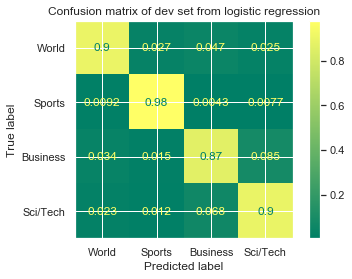

In [59]:
#plotting a confusion matrix (on dev set) for our Hulk
from sklearn.metrics import plot_confusion_matrix
sns.set_context('notebook')
class_names=list(classes.values())
disp = plot_confusion_matrix(baselogistic_classifier, X_dev1, y_dev,
                                 display_labels=class_names,
                                 cmap='summer',
                                 normalize='true')
print(disp.confusion_matrix)
disp.ax_.set_title('Confusion matrix of dev set from logistic regression')


# Improve the basic logistic regression 

In the following sections we will try to improve the performance of the baseline logistic classifier. 

## 4.1.2.1 Change input matrix

Now we try to fit again the Logistic Regression, changing this time the max and min doc frequency in building the tfidf vectorizer. We are going to do this because the Logistic Regression Baseline is very powerful and as you can see no other model is going to beat it. Therefore it might be a good idea trying to make the Hulk better instead of beating it (for this reason in the next cells we are going to regularize it and perform feature selection). 

Here we increase the minimum number of documents in which a word has to be present in order to be considered and the maximum number of documents in which a word can appear. In this way, by removing the most frequent words that might add some noise and including the rare words that might be helpful in discover something else we hope in a better performance 

In [60]:
tfidf_vectorizer2 = TfidfVectorizer(ngram_range=(2,6), min_df=0.0001, max_df=0.5, analyzer='char')

X_train2 = tfidf_vectorizer2.fit_transform(train_set['Full_Text']) # training model matrix
print(X_train2.shape) # lots of features

(102080, 292121)


In [61]:
X_dev2 = tfidf_vectorizer2.transform(dev_set['Full_Text'])
X_test2 = tfidf_vectorizer2.transform(test_set['Full_Text'])
print(X_dev2.shape, X_test2.shape)

(12760, 292121) (12760, 292121)


In [62]:
# run a logistic regression with the new input matrix
baselogistic_classifier2 = LogisticRegression(n_jobs=cores, multi_class='auto', solver='lbfgs') # standard setting

# fit the classifier
%time baselogistic_classifier2.fit(X_train2, y_train)

baselogistic_classifier2_predictions =baselogistic_classifier2.predict(X_dev2)  # keeping this predictions as baseline

# print the classification report
print(classification_report(y_dev,baselogistic_classifier2_predictions))

Wall time: 1min 12s
              precision    recall  f1-score   support

           1       0.93      0.90      0.92      3190
           2       0.95      0.98      0.97      3257
           3       0.89      0.87      0.88      3143
           4       0.89      0.91      0.90      3170

    accuracy                           0.92     12760
   macro avg       0.92      0.92      0.92     12760
weighted avg       0.92      0.92      0.92     12760



In [63]:
# get the scores of the new logistic regression on the dev set
baselogistic_classifier2_accuracy = baselogistic_classifier2.score(X_dev2, y_dev)
print('The accuracy of the second logistic regression on dev data is: {}'.format(round(baselogistic_classifier2_accuracy,4)))

The accuracy of the second logistic regression on dev data is: 0.9161


In [64]:
# compute the difference between the two logistic regressions
diff = baselogistic_classifier2_accuracy - baselogistic_classifier_accuracy
print('The difference between the two logistic regressions is {}'.format(round(diff,4)))

The difference between the two logistic regressions is 0.0048


Here, by changing min and max doc frequency in the tfidf vectorizer we have improved the performance of Logistic regression a bit

## 4.1.2.2 Change weights

Reading the classification report, we noticed that the baseline predicts almost perfectly the second class while it struggles a bit more on the other three. Therefore it could be a good idea to assign different weight to the four classes and check if the performance improve

In [65]:
# create a dictionary with the class weights
class_weights = {1: 5,
                2: 1,
                3: 5,
                4: 5}

# init a lg
weighted_lr = LogisticRegression(n_jobs=cores, multi_class='auto', solver='lbfgs', class_weight=class_weights)

# fit the model
weighted_lr.fit(X_train2, y_train)

# get the scores 
weighted_lr.score(X_dev2, y_dev)

# get the predictions
weighted_lr_predictions = weighted_lr.predict(X_dev2)

# chech the classification report
print(classification_report(y_dev,weighted_lr_predictions))

              precision    recall  f1-score   support

           1       0.90      0.91      0.91      3190
           2       0.98      0.93      0.95      3257
           3       0.87      0.88      0.87      3143
           4       0.88      0.91      0.89      3170

    accuracy                           0.91     12760
   macro avg       0.91      0.91      0.91     12760
weighted avg       0.91      0.91      0.91     12760



In [66]:
weighted_lr.score(X_dev2, y_dev)

0.9076802507836991

## 4.1.2.3 Regularization Strength

In order to get better results, we can now try to use different values of regularization strength. With regularization strength we try to avoid overfitting by adding a new term in the loss function which penalizes high values of the parameters.

In [67]:
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, classification_report
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

In [68]:
# Using word level 1-2-words reduces the number of features to <4k which makes things faster for some algorithms
# Otherwise some dim reduction on the char 2-6 first might be needed
word_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=0.001, 
                             max_df=0.7, 
                             analyzer='word')

X_train_word = word_vectorizer.fit_transform(train_set['Full_Text'])
print(X_train_word.shape)
X_dev_word = word_vectorizer.transform(dev_set['Full_Text'])
X_test_word = word_vectorizer.transform(test_set['Full_Text'])

(102080, 3689)


In [69]:
# create a function to find the optimal value of regularization strength
def regularize(X_train, y_train , X_dev ,y_dev ,seq = [50,30,20,10,5,1,0.5,0.01,0.001], solver = 'lbfgs'): 
    
    best_c = None
    best_performance=0.0

    for c in seq:
        print("Current C: {}".format(c))
        # initiate the classifier with different values of C
        classifier_c = LogisticRegression(n_jobs=cores, 
                                              multi_class = 'multinomial', 
                                              solver = solver,
                                              C=c) #comparisons changing only this parameter
        
        # fit the model
        classifier_c.fit(X_train, y_train)
        
        #predictions_c = classifier_c.predict(X_dev_word)
        
        # get the accuracy on the dev set
        score = classifier_c.score(X_dev, y_dev)
        
        # check if the score improved
        if score > best_performance:
            best_performance=score
            best_c=c
            print("New best performance: {}".format(best_performance))
        
    return best_c

In [70]:
# We look at results with default sequence so we can 'zoom' in to the best number
#best_c1 = regularize(X_train=X_train_word, y_train=y_train, X_dev=X_dev_word, y_dev=y_dev , solver = 'lbfgs')

In [72]:
# try to regularize using the 2-6char_ngrams as input
best_c = regularize(X_train=X_train2, y_train=y_train, X_dev=X_dev2, y_dev=y_dev,seq = [5,3,2,1.5,1,0.5,0.1,0.05,0.01], solver = 'lbfgs')

Current C: 5
New best performance: 0.9144200626959248
Current C: 3
New best performance: 0.9163009404388714
Current C: 2
New best performance: 0.9171630094043887
Current C: 1.5
Current C: 1
Current C: 0.5
Current C: 0.1
Current C: 0.05
Current C: 0.01


In [76]:
print(best_c)

2


## 4.1.2.4 Feature selection

To make our logistic classifier better we can also try to use only those features with the greater output predictive ability, and in this way to reduce variability, by considering those with the highest correlation with the target

In [77]:
from sklearn.feature_selection import SelectKBest, chi2
def find_k_selector(k_list_selector, X_train, y_trian, X_dev, y_dev):
    
    best_k = None
    best_k_performance = 0.0
    
    for k in k_list_selector:
        print("Current k: {}".format(k))
        
        # initiate the selector
        selector_k = SelectKBest(chi2, k=k).fit(X_train, y_train)

        X_train_sel = selector_k.transform(X_train)
        X_dev_sel = selector_k.transform(X_dev)

        # initiate a lr
        logistic_sel = LogisticRegression(n_jobs=cores, 
                                          multi_class='multinomial', 
                                          solver='lbfgs',
                                          C = best_c # From right above 
                                         )
        # fit
        logistic_sel.fit(X_train_sel, y_train)

        # get the scores
        sel_score = logistic_sel.score(X_dev_sel,y_dev)

        if sel_score > best_k_performance:
            best_k_performance = sel_score
            best_k = k
            print("New best performance: {}".format(best_k_performance))

    return best_k

In [78]:
k_list_selector = [10000, 20000, 40000, 80000, 120000]
best_k_selector = find_k_selector(k_list_selector, X_train2, y_train, X_dev2, y_dev)

Current k: 10000
New best performance: 0.8963949843260188
Current k: 20000
New best performance: 0.9044670846394984
Current k: 40000
New best performance: 0.9088557993730407
Current k: 80000
New best performance: 0.9129310344827586
Current k: 120000
New best performance: 0.915282131661442


Of course by pushing k up the performance improve

## 4.1.3 Naive Bayes

After having tried to improve th performance of the logistic regression, we try now to perform a Naive Bayes classifier and see whether it is able to beat the baseline.

In [80]:
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

NB_classifier=MultinomialNB(alpha=1,fit_prior=True,class_prior=None)
%time NB_classifier.fit(X_train2, y_train)
print(NB_classifier)

# chech the score on the dev set
NB_classifier.score(X_dev2, y_dev)

Wall time: 442 ms
MultinomialNB(alpha=1, class_prior=None, fit_prior=True)


0.9018025078369906

In [81]:
# get the predictions on the test set
NB_predictions = NB_classifier.predict(X_test2)
print(classification_report(y_test,NB_predictions))

              precision    recall  f1-score   support

           1       0.92      0.89      0.90      3242
           2       0.95      0.97      0.96      3106
           3       0.87      0.86      0.86      3156
           4       0.87      0.88      0.88      3256

    accuracy                           0.90     12760
   macro avg       0.90      0.90      0.90     12760
weighted avg       0.90      0.90      0.90     12760



In [82]:
# create a functiona to find the optimal value of alpha
def find_alpha(alpha_list, X_train, y_train, X_dev, y_dev):
    
    #alpha_scores = []
    best_alpha = None
    best_performance_alpha = 0.0

    for temp_alpha in alpha_list:
        # initiate a classifier
        NB_classifier_alpha = MultinomialNB(alpha=temp_alpha,fit_prior=True,class_prior=None)
        # fit the model
        NB_classifier_alpha.fit(X_train, y_train)

        # get the accuracy on the dev set
        score = NB_classifier_alpha.score(X_dev, y_dev)

        if score > best_performance_alpha:
            best_performance_alpha = score
            best_alpha = temp_alpha
            print('New best alpha: {}'.format(best_alpha))
            print("New best performance: {}".format(score))
            
            
    return best_alpha

In [83]:
alpha_list = np.arange(0,1,1/50)
alpha1 = find_alpha(alpha_list, X_train2, y_train, X_dev2, y_dev)

C:\Users\cirib\anaconda3\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


New best alpha: 0.0
New best performance: 0.904858934169279
New best alpha: 0.02
New best performance: 0.9075235109717869
New best alpha: 0.04
New best performance: 0.9078369905956113


In [84]:
# the best value of alpha seems to be around 0.04 so we can make a narrower research in that area
alpha_list = np.arange(0.02,0.05,0.0005)
alpha2 = find_alpha(alpha_list, X_train2, y_train, X_dev2, y_dev)

New best alpha: 0.02
New best performance: 0.9075235109717869
New best alpha: 0.024000000000000004
New best performance: 0.907601880877743
New best alpha: 0.024500000000000004
New best performance: 0.9076802507836991
New best alpha: 0.033500000000000016
New best performance: 0.9077586206896552
New best alpha: 0.03700000000000002
New best performance: 0.9078369905956113
New best alpha: 0.03750000000000002
New best performance: 0.9079153605015674


In [85]:
# alpha = 0.0375
NB_classifier_improved = MultinomialNB(alpha=alpha2,fit_prior=True,class_prior=None)
NB_classifier_improved.fit(X_train2, y_train)

# check the score on the dev set
NB_classifier_improved.score(X_dev2, y_dev)

# get the predictions on the test set
NB_predictions_improved = NB_classifier_improved.predict(X_test2)

## 4.1.4 KNN

Anothe simple yet effective classification algorithm we can implement is KNN

In [87]:
# try with KNN
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3,n_jobs = cores)

In [88]:
# fit the model
%time neigh.fit(X_train2, y_train)

Wall time: 302 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=7, n_neighbors=3, p=2,
                     weights='uniform')

In [89]:
# get the scores on the dev set
%time neigh.score(X_dev2, y_dev)

Wall time: 1min 3s


0.90141065830721

In [90]:
def find_neighbor(neighbor_list, X_train, y_train, X_dev, y_dev):
    
    best_n = None
    best_n_performance = 0.0
    
    for n in neighbor_list:
        
        print('Current n: {}'.format(n))
        # initiate a KNN classifier
        n_neigh = KNeighborsClassifier(n_neighbors=n,n_jobs = cores)
        
        # fit the models
        n_neigh.fit(X_train, y_train)
        
        # get the accuracy
        n_neigh_score = n_neigh.score(X_dev,y_dev)
        
        if n_neigh_score > best_n_performance:
            best_n_performance = n_neigh_score
            best_n = n
            print('New best k: {}'.format(best_n))
            print("New best performance: {}".format(n_neigh_score))
            
    return best_n

In [91]:
neighbor_list = [1,3,5,7,9,11]
best_n = find_neighbor(neighbor_list, X_train2, y_train, X_dev2, y_dev)

Current n: 1
New best k: 1
New best performance: 0.8870689655172413
Current n: 3
New best k: 3
New best performance: 0.90141065830721
Current n: 5
New best k: 5
New best performance: 0.9076802507836991
Current n: 7
New best k: 7
New best performance: 0.908307210031348
Current n: 9
Current n: 11


It seems like 7 is the optimal number of neighbours (might change depending on the initial shuffling)

In [92]:
#run a new knn with k = 7
neigh_improved = KNeighborsClassifier(n_neighbors=best_n,n_jobs = cores)

# fit
neigh_improved.fit(X_train2, y_train)

# get the scores on the dev set
%time neigh_improved.score(X_dev2, y_dev)

Wall time: 1min 8s


0.908307210031348

Even after the optimization, the dev accuracy is still quite far from that of the logistic regression.

## 4.1.5 Random Forest

In [93]:
from sklearn.ensemble import RandomForestClassifier

In [94]:
# sqrt of the features is how many variables it chooses from to form a split
print(X_train_word.shape, np.sqrt(X_train_word.shape[1])) 

(102080, 3689) 60.73713855624086


In [95]:
# m=sqrt(p) 
rf_class = RandomForestClassifier(max_features='sqrt', 
                                      random_state=1, 
                                      n_estimators=250,   
                                      n_jobs = cores) 
rf_class.fit(X_train_word, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=7,
                       oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [96]:
# get the predictions
rf_prediction = rf_class.predict(X_dev_word)
#print(classification_report(y_dev,rf_prediction))

# check the scores
# NB_classifier_improved.score(X_dev2, y_dev)
rf_class.score(X_dev_word, y_dev)


0.8880094043887148

The performance of the basic random forest is slightly worse than the one of NB.

<a id=cnn></a>
## 4.1.6 Convolutional Neural Network

[Back on top](#top)

In [97]:
# check the had of the dataframe
full.head(1)

,Class,Title,Article,Labels,Article_clean,Title_clean,Full_Text,Article_tokens_before,Title_tokens_before,Article_tokens_after,Title_tokens_after
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Business,short seller wall street dwindle band ultra cy...,wall bear claw black,wall bear claw black short seller wall street ...,12,9,10,4


In [98]:
#############################################################################################
# Need to have run all the first part (1.1, 1.2) and the splitting in classification (4.1) #
#############################################################################################

# get the train instances as a list of strings
train_instances = full['Full_Text'][:train_size].apply(str).apply(str.split)
# get the train labels
train_labels = full['Labels'][:train_size]
# print(train_labels[:5])

In [99]:
# collect known word tokens and labels
wordset, labelset = set(), set()

# get a set of the different labels
labelset.update(set(full['Labels']))

# update the wordset
for words in train_instances:
    wordset.update(set(words))

In [100]:
# map words and tags into integers
# reserved tokens for padding and unkonwn words
PAD = '-PAD-'
UNK = '-UNK-'

# translate all the words into integers
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  # special token for padding
word2int[UNK] = 1  # special token for unknown words

In [101]:
def convert2ints(instances):
    """
    takes a list of words as input and returns a list of integers 
    corresponding to the words taken from the word2int dictionary
    """
    
    # create a list where to store the results
    result = []
    
    # iterate over the owrds
    for words in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words]
        result.append(word_ints)
        
    return result

In [102]:
# create dictionary that goes from lables to numbers 
label2int = {label: i for i, label in enumerate(sorted(labelset))}
# and another that translates it back from numbers to labels
int2label = {i:label for label, i in label2int.items()}

# this time there is no need to add a special token for unkown since all tags are known
int2label[PAD] = 0

# change trianing instances from words to numbers
train_instances_int = convert2ints(train_instances)
train_labels_int = [label2int[label] for label in train_labels]

In [103]:
# make sure that everyhting is a string
# convert dev data
dev_instances = full['Full_Text'][train_size: train_size+dev_size].apply(str).apply(str.split)
# select dev labels
dev_labels = full['Labels'][train_size: train_size+dev_size]

# convert words and labels to integers
dev_instances_int = convert2ints(dev_instances)
dev_labels_int = [label2int[label] for label in dev_labels]

# convert test data 
test_instances = full['Full_Text'][train_size+dev_size:].apply(str).apply(str.split)
# select the test labels
test_labels = full['Labels'][train_size+dev_size:]

# convert words and labels to integers
test_instances_int = convert2ints(test_instances)
test_labels_int = [label2int[label] for label in test_labels]

In [105]:
from keras.utils import to_categorical

# do the one-hot encoding of the labels
train_labels_1hot = to_categorical(train_labels_int, len(label2int))
test_labels_1hot = to_categorical(test_labels_int, len(label2int))
dev_labels_1hot = to_categorical(dev_labels_int, len(label2int))

In [106]:
# compute 95th percentile of training sentence lengths
L = sorted(map(len, train_instances))
MAX_LENGTH_CNN = L[int(len(L)*0.95)]
print(MAX_LENGTH_CNN)

# apply padding
from keras.preprocessing.sequence import pad_sequences
train_instances_int_padded = pad_sequences(train_instances_int, padding='post', maxlen=MAX_LENGTH_CNN)
test_instances_int_padded = pad_sequences(test_instances_int, padding='post', maxlen=MAX_LENGTH_CNN)
dev_instances_int_padded = pad_sequences(dev_instances_int, padding='post', maxlen=MAX_LENGTH_CNN)

33


In [107]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers import GlobalMaxPooling1D, Dropout
from keras.layers.core import Dense, Activation
import numpy as np

#class cnn_model():
class CNN_model():
    """
    implement a CNN model in keras
    """
    
    def __init__(self,
                 MAX_LENGTH_CNN:int,
                 word2int:dict, 
                 label2int:dict,
                 loss:str,
                 optimizer:str,
                 metrics:list,
                ):
        
        self.MAX_LENGTH_CNN = MAX_LENGTH_CNN
        self.word2int = word2int
        self.label2int = label2int
        self.loss = loss,
        self.optimizer = optimizer
        self.metrics = metrics
        
    def create_model(self, embedding_output_dim:int, nb_filter:int,
                     filter_length:int, stride_lenght:int,
                     drop_out_rate1:int, dense_hidden_dim:int,
                     drop_out_rate2:int, print_summary = False
                    ):
        """
        creates a keras cnn model with the following structure
        """
        
        # set random seed for replicability
        np.random.seed(42)
        
        # first layer of the cnn
        self.inputs = Input((self.MAX_LENGTH_CNN, ), 
                               name='word_IDs')
        
        # create a dense embedding
        self.embeddings = Embedding(input_dim=len(self.word2int), 
                               output_dim=embedding_output_dim, 
                               name='embeddings')(self.inputs)
        
        # convolution
        self.convolution = Conv1D(filters=nb_filter,  
                                  kernel_size=filter_length, 
                                  padding='same',  
                                  activation='relu',
                                  strides=stride_lenght)(self.embeddings)

        # applyt thanh activation
        self.convolution2 = Activation(activation='tanh')(self.convolution)
        
        # go over each columns and select the max value in the column
        self.pooling = GlobalMaxPooling1D()(self.convolution2)
        
        # drop out 20% 
        self.dropout1 = Dropout(drop_out_rate1)(self.pooling)
        
        # dense
        self.dense = Dense(dense_hidden_dim, activation='relu')(self.dropout1)
        
        # apply another dropout
        self.dropout2 = Dropout(drop_out_rate2)(self.dense)
        
        # transform into a probability distribution over the four possible labels
        self.output = Dense(len(label2int), activation='softmax')(self.dropout2)
        
        # initiate the model
        self.model = Model(inputs=[self.inputs], outputs=[self.output])
        
        if print_summary:
            print(self.model.summary())

        return self.model
        
        
    def compile_model(self, model, metrics):
        """
        configures the model for training
        """
        
        model.compile(loss = self.loss, optimizer=self.optimizer, metrics = metrics
                     )

    def fit_model(self, model, train_instances_int_padded, train_labels_1hot, batch_size:int, epochs:int,
                  verbose:int, validation_data: tuple,):
        
        """
        fits the model
        """
        self.history = model.fit(train_instances_int_padded, train_labels_1hot, batch_size= batch_size,
                                 epochs = epochs, verbose = verbose, validation_data = validation_data)
        
        return self.history       

In [108]:
# initiate cnn model
cnn_basic = CNN_model(MAX_LENGTH_CNN, word2int, label2int,'categorical_crossentropy', 'adam',['Accuracy'])

In [109]:
# set the parameters of the model
batch_size = 1024
epochs = 5
verbose = 1
validation_data = (dev_instances_int_padded, dev_labels_1hot)
embedding_output_dim = 64
nb_filter = 64 
filter_length = 3
stride_lenght = 1
drop_out_rate1 = 0.2
dense_hidden_dim = 32
drop_out_rate2 = 0.2

cnn_model_basic = cnn_basic.create_model(embedding_output_dim, nb_filter, filter_length,
                  stride_lenght, drop_out_rate1, dense_hidden_dim, 
                  drop_out_rate2, True
                 )

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_IDs (InputLayer)        (None, 33)                0         
_________________________________________________________________
embeddings (Embedding)       (None, 33, 64)            2802112   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 33, 64)            12352     
_________________________________________________________________
activation_1 (Activation)    (None, 33, 64)            0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080

In [110]:
# compile the model
cnn_basic.compile_model(cnn_model_basic, ['accuracy'])

In [111]:
history_cnn_basic = cnn_basic.fit_model(cnn_model_basic,train_instances_int_padded,
                      train_labels_1hot,
                      batch_size, 
                      epochs,
                      verbose,
                      validation_data,
                     )

C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 5s 50us/step - loss: 0.9200 - accuracy: 0.6745 - val_loss: 0.3406 - val_accuracy: 0.8901
Epoch 2/5
102080/102080 [==============================] - 5s 48us/step - loss: 0.3257 - accuracy: 0.8990 - val_loss: 0.2777 - val_accuracy: 0.9092
Epoch 3/5
102080/102080 [==============================] - 5s 48us/step - loss: 0.2434 - accuracy: 0.9248 - val_loss: 0.2703 - val_accuracy: 0.9094
Epoch 4/5
102080/102080 [==============================] - 5s 50us/step - loss: 0.1957 - accuracy: 0.9385 - val_loss: 0.2733 - val_accuracy: 0.9092
Epoch 5/5
102080/102080 [==============================] - 5s 48us/step - loss: 0.1595 - accuracy: 0.9500 - val_loss: 0.2907 - val_accuracy: 0.9038


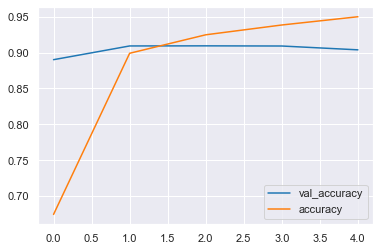

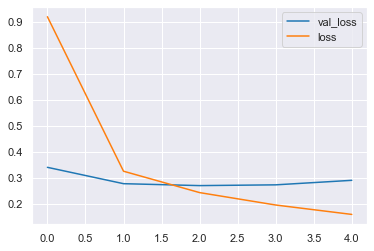

In [112]:
# plot the accuracy and the loss
%matplotlib inline
df = pd.DataFrame(history_cnn_basic.history)
df[['val_accuracy', 'accuracy']].plot.line();
df[['val_loss', 'loss']].plot.line();

In the first graph the training accuracy keep increasing while the validation accuracy remains constant during the first 2 epoch and then slightly decreases. This result may suggest that the model is overfitting. Similarly, in the second plot the training loss is always decreasing while the validation loss increases sharply after the second epoch. 

In [113]:
# get the predictions on the dev test to check later on whether the optmization was successfull
cnn_prediction_basic = cnn_model_basic.predict(test_instances_int_padded)

In [114]:
def find_best(histories, param_list):
    """
    takes a list of lists as input, find the best value among all values
    and return the corresponding parameter
    """
    best = None
    
    temp = []
    # iterate over the different models
    for model in histories:
        # find the best value of each model
        model_best = max(model)
        temp.append(model_best)
    
    # find the global maximum
    global_best = temp.index(max(temp))
    # print(global_best)
    
    # get the corresponding value of the parameter
    return param_list[global_best]

### 4.1.6.1 Find best filter size

In [115]:
nb_filter_list = [16,32,64,128,256]
nb_filter_histories = []

# initiate the model
cnn_filter_size = CNN_model(MAX_LENGTH_CNN, word2int, label2int,'categorical_crossentropy', 'adam',['Accuracy'])

for temp_nb_filter in nb_filter_list:
    print("Training with filter dimension: {}".format(temp_nb_filter))
    # create the model
    cnn_model = cnn_filter_size.create_model(embedding_output_dim, temp_nb_filter, filter_length,
                  stride_lenght, drop_out_rate1, dense_hidden_dim, 
                  drop_out_rate2, False
                 )
    
    # compile the model
    cnn_filter_size.compile_model(cnn_model, ['accuracy'])

    # fit the model
    history_cnn = cnn_filter_size.fit_model(cnn_model,train_instances_int_padded, 
                                      train_labels_1hot,
                                      batch_size, 
                                      epochs,
                                      verbose,
                                      validation_data,
                                      )
    
    histories_temp = history_cnn.history['val_accuracy']
    nb_filter_histories.append(histories_temp)

Training with filter dimension: 16


C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 4s 42us/step - loss: 1.0740 - accuracy: 0.6232 - val_loss: 0.5316 - val_accuracy: 0.8669
Epoch 2/5
102080/102080 [==============================] - 4s 41us/step - loss: 0.4536 - accuracy: 0.8647 - val_loss: 0.3193 - val_accuracy: 0.8998
Epoch 3/5
102080/102080 [==============================] - 4s 41us/step - loss: 0.3280 - accuracy: 0.9019 - val_loss: 0.2965 - val_accuracy: 0.9039
Epoch 4/5
102080/102080 [==============================] - 4s 41us/step - loss: 0.2724 - accuracy: 0.9198 - val_loss: 0.2890 - val_accuracy: 0.9073
Epoch 5/5
102080/102080 [==============================] - 4s 42us/step - loss: 0.2364 - accuracy: 0.9297 - val_loss: 0.2911 - val_accuracy: 0.9041
Training with filter dimension: 32


C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 4s 44us/step - loss: 0.9817 - accuracy: 0.6783 - val_loss: 0.3906 - val_accuracy: 0.8795
Epoch 2/5
102080/102080 [==============================] - 4s 43us/step - loss: 0.3618 - accuracy: 0.8883 - val_loss: 0.2892 - val_accuracy: 0.9064
Epoch 3/5
102080/102080 [==============================] - 4s 43us/step - loss: 0.2739 - accuracy: 0.9163 - val_loss: 0.2773 - val_accuracy: 0.9091
Epoch 4/5
102080/102080 [==============================] - 4s 43us/step - loss: 0.2254 - accuracy: 0.9322 - val_loss: 0.2783 - val_accuracy: 0.9089
Epoch 5/5
102080/102080 [==============================] - 4s 43us/step - loss: 0.1886 - accuracy: 0.9426 - val_loss: 0.2883 - val_accuracy: 0.9067
Training with filter dimension: 64


C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 5s 49us/step - loss: 0.8909 - accuracy: 0.6999 - val_loss: 0.3287 - val_accuracy: 0.8922
Epoch 2/5
102080/102080 [==============================] - 5s 49us/step - loss: 0.3164 - accuracy: 0.9016 - val_loss: 0.2802 - val_accuracy: 0.9105
Epoch 3/5
102080/102080 [==============================] - 5s 49us/step - loss: 0.2425 - accuracy: 0.9255 - val_loss: 0.2764 - val_accuracy: 0.9102
Epoch 4/5
102080/102080 [==============================] - 5s 49us/step - loss: 0.1978 - accuracy: 0.9395 - val_loss: 0.2807 - val_accuracy: 0.9092
Epoch 5/5
102080/102080 [==============================] - 5s 49us/step - loss: 0.1629 - accuracy: 0.9490 - val_loss: 0.3013 - val_accuracy: 0.9039
Training with filter dimension: 128


C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 6s 64us/step - loss: 0.8344 - accuracy: 0.7087 - val_loss: 0.3113 - val_accuracy: 0.8959
Epoch 2/5
102080/102080 [==============================] - 6s 63us/step - loss: 0.2953 - accuracy: 0.9076 - val_loss: 0.2740 - val_accuracy: 0.9094
Epoch 3/5
102080/102080 [==============================] - 6s 63us/step - loss: 0.2266 - accuracy: 0.9293 - val_loss: 0.2769 - val_accuracy: 0.9097
Epoch 4/5
102080/102080 [==============================] - 6s 63us/step - loss: 0.1816 - accuracy: 0.9434 - val_loss: 0.2844 - val_accuracy: 0.9064
Epoch 5/5
102080/102080 [==============================] - 7s 64us/step - loss: 0.1489 - accuracy: 0.9533 - val_loss: 0.3051 - val_accuracy: 0.9013
Training with filter dimension: 256


C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 11s 105us/step - loss: 0.7605 - accuracy: 0.7465 - val_loss: 0.2948 - val_accuracy: 0.9030
Epoch 2/5
102080/102080 [==============================] - 11s 104us/step - loss: 0.2743 - accuracy: 0.9141 - val_loss: 0.2703 - val_accuracy: 0.9084
Epoch 3/5
102080/102080 [==============================] - 11s 104us/step - loss: 0.2093 - accuracy: 0.9338 - val_loss: 0.2794 - val_accuracy: 0.9072
Epoch 4/5
102080/102080 [==============================] - 11s 104us/step - loss: 0.1676 - accuracy: 0.9464 - val_loss: 0.2907 - val_accuracy: 0.9048
Epoch 5/5
102080/102080 [==============================] - 11s 104us/step - loss: 0.1349 - accuracy: 0.9562 - val_loss: 0.3211 - val_accuracy: 0.9010


In [116]:
best_nb_filter = find_best(nb_filter_histories, nb_filter_list)
print('the best embedding dimension is {}'.format(best_nb_filter))

the best embedding dimension is 64


### 4.1.6.2 Find best filter length

In [117]:
filter_length_list = [2,3,4,6,8]
filter_length_histories = []

# initiate the model
cnn_filter_length = CNN_model(MAX_LENGTH_CNN, word2int, label2int,'categorical_crossentropy', 'adam',['Accuracy'])

for temp_filter_length in filter_length_list:
    print("Training with filter length: {}".format(temp_filter_length))
    # create the model
    cnn_model = cnn_filter_length.create_model(embedding_output_dim, best_nb_filter, temp_filter_length,
                  stride_lenght, drop_out_rate1, dense_hidden_dim, 
                  drop_out_rate2, False
                 )
    
    # compile the model
    cnn_filter_length.compile_model(cnn_model, ['accuracy'])

    # fit the model
    history_cnn = cnn_filter_length.fit_model(cnn_model,train_instances_int_padded, 
                                      train_labels_1hot,
                                      batch_size, 
                                      epochs,
                                      verbose,
                                      validation_data,
                                      )
    
    histories_temp = history_cnn.history['val_accuracy']
    filter_length_histories.append(histories_temp)

Training with filter length: 2


C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 5s 48us/step - loss: 0.8676 - accuracy: 0.7200 - val_loss: 0.3458 - val_accuracy: 0.8859
Epoch 2/5
102080/102080 [==============================] - 5s 47us/step - loss: 0.3243 - accuracy: 0.8978 - val_loss: 0.2872 - val_accuracy: 0.9049
Epoch 3/5
102080/102080 [==============================] - 5s 47us/step - loss: 0.2535 - accuracy: 0.9218 - val_loss: 0.2745 - val_accuracy: 0.9086
Epoch 4/5
102080/102080 [==============================] - 5s 47us/step - loss: 0.2082 - accuracy: 0.9351 - val_loss: 0.2729 - val_accuracy: 0.9095
Epoch 5/5
102080/102080 [==============================] - 5s 47us/step - loss: 0.1739 - accuracy: 0.9453 - val_loss: 0.2881 - val_accuracy: 0.9043
Training with filter length: 3


C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 5s 50us/step - loss: 0.9072 - accuracy: 0.6955 - val_loss: 0.3459 - val_accuracy: 0.8889
Epoch 2/5
102080/102080 [==============================] - 5s 49us/step - loss: 0.3281 - accuracy: 0.8983 - val_loss: 0.2853 - val_accuracy: 0.9048
Epoch 3/5
102080/102080 [==============================] - 5s 49us/step - loss: 0.2508 - accuracy: 0.9224 - val_loss: 0.2792 - val_accuracy: 0.9066
Epoch 4/5
102080/102080 [==============================] - 5s 49us/step - loss: 0.2040 - accuracy: 0.9376 - val_loss: 0.2793 - val_accuracy: 0.9063
Epoch 5/5
102080/102080 [==============================] - 5s 49us/step - loss: 0.1692 - accuracy: 0.9474 - val_loss: 0.2947 - val_accuracy: 0.9042
Training with filter length: 4


C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 5s 52us/step - loss: 0.8725 - accuracy: 0.6985 - val_loss: 0.3200 - val_accuracy: 0.8940
Epoch 2/5
102080/102080 [==============================] - 5s 51us/step - loss: 0.3051 - accuracy: 0.9052 - val_loss: 0.2768 - val_accuracy: 0.9100
Epoch 3/5
102080/102080 [==============================] - 5s 52us/step - loss: 0.2341 - accuracy: 0.9275 - val_loss: 0.2740 - val_accuracy: 0.9099
Epoch 4/5
102080/102080 [==============================] - 5s 52us/step - loss: 0.1915 - accuracy: 0.9406 - val_loss: 0.2801 - val_accuracy: 0.9073
Epoch 5/5
102080/102080 [==============================] - 5s 51us/step - loss: 0.1584 - accuracy: 0.9505 - val_loss: 0.3017 - val_accuracy: 0.9026
Training with filter length: 6


C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 6s 56us/step - loss: 0.8641 - accuracy: 0.6906 - val_loss: 0.3074 - val_accuracy: 0.8970
Epoch 2/5
102080/102080 [==============================] - 6s 55us/step - loss: 0.3016 - accuracy: 0.9081 - val_loss: 0.2759 - val_accuracy: 0.9073
Epoch 3/5
102080/102080 [==============================] - 6s 55us/step - loss: 0.2337 - accuracy: 0.9290 - val_loss: 0.2760 - val_accuracy: 0.9080
Epoch 4/5
102080/102080 [==============================] - 6s 56us/step - loss: 0.1925 - accuracy: 0.9417 - val_loss: 0.2847 - val_accuracy: 0.9048
Epoch 5/5
102080/102080 [==============================] - 6s 56us/step - loss: 0.1600 - accuracy: 0.9512 - val_loss: 0.3034 - val_accuracy: 0.9011
Training with filter length: 8


C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 6s 62us/step - loss: 0.8074 - accuracy: 0.7278 - val_loss: 0.2968 - val_accuracy: 0.9003
Epoch 2/5
102080/102080 [==============================] - 6s 60us/step - loss: 0.2824 - accuracy: 0.9135 - val_loss: 0.2729 - val_accuracy: 0.9084
Epoch 3/5
102080/102080 [==============================] - 6s 61us/step - loss: 0.2188 - accuracy: 0.9328 - val_loss: 0.2793 - val_accuracy: 0.9056
Epoch 4/5
102080/102080 [==============================] - 6s 62us/step - loss: 0.1788 - accuracy: 0.9455 - val_loss: 0.2875 - val_accuracy: 0.9047
Epoch 5/5
102080/102080 [==============================] - 6s 61us/step - loss: 0.1487 - accuracy: 0.9544 - val_loss: 0.3099 - val_accuracy: 0.9005


In [118]:
best_filter_length = find_best(filter_length_histories, filter_length_list)
print('the best filter is {}'.format(best_filter_length))

the best filter is 4


### 4.1.6.3 Find best stride length

In [119]:
stride_length_list = [1,2,3]
stride_length_histories = []

# initiate the model
cnn_stride_length = CNN_model(MAX_LENGTH_CNN, word2int, label2int,'categorical_crossentropy', 'adam',['Accuracy'])

for temp_stride_length in stride_length_list:
    print("Training with stride length: {}".format(temp_stride_length))
    # create the model
    cnn_model = cnn_filter_length.create_model(embedding_output_dim, best_nb_filter, best_filter_length,
                  temp_stride_length, drop_out_rate1, dense_hidden_dim, 
                  drop_out_rate2, False
                 )
    
    # compile the model
    cnn_stride_length.compile_model(cnn_model, ['accuracy'])

    # fit the model
    history_cnn = cnn_stride_length.fit_model(cnn_model,train_instances_int_padded, 
                                      train_labels_1hot,
                                      batch_size, 
                                      epochs,
                                      verbose,
                                      validation_data,
                                      )
    
    histories_temp = history_cnn.history['val_accuracy']
    stride_length_histories.append(histories_temp)

Training with stride length: 1


C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 5s 51us/step - loss: 0.8576 - accuracy: 0.7199 - val_loss: 0.3208 - val_accuracy: 0.8953
Epoch 2/5
102080/102080 [==============================] - 5s 50us/step - loss: 0.3129 - accuracy: 0.9037 - val_loss: 0.2782 - val_accuracy: 0.9082
Epoch 3/5
102080/102080 [==============================] - 5s 50us/step - loss: 0.2388 - accuracy: 0.9270 - val_loss: 0.2769 - val_accuracy: 0.9067
Epoch 4/5
102080/102080 [==============================] - 5s 50us/step - loss: 0.1942 - accuracy: 0.9401 - val_loss: 0.2811 - val_accuracy: 0.9065
Epoch 5/5
102080/102080 [==============================] - 5s 50us/step - loss: 0.1593 - accuracy: 0.9504 - val_loss: 0.2998 - val_accuracy: 0.9034
Training with stride length: 2


C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 4s 42us/step - loss: 0.8891 - accuracy: 0.6950 - val_loss: 0.3216 - val_accuracy: 0.8913
Epoch 2/5
102080/102080 [==============================] - 4s 41us/step - loss: 0.3101 - accuracy: 0.9030 - val_loss: 0.2781 - val_accuracy: 0.9070
Epoch 3/5
102080/102080 [==============================] - 4s 42us/step - loss: 0.2363 - accuracy: 0.9264 - val_loss: 0.2766 - val_accuracy: 0.9067
Epoch 4/5
102080/102080 [==============================] - 4s 42us/step - loss: 0.1891 - accuracy: 0.9404 - val_loss: 0.2837 - val_accuracy: 0.9061
Epoch 5/5
102080/102080 [==============================] - 4s 41us/step - loss: 0.1533 - accuracy: 0.9518 - val_loss: 0.3063 - val_accuracy: 0.9014
Training with stride length: 3


C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 4s 39us/step - loss: 0.8980 - accuracy: 0.6912 - val_loss: 0.3313 - val_accuracy: 0.8900
Epoch 2/5
102080/102080 [==============================] - 4s 37us/step - loss: 0.3131 - accuracy: 0.9035 - val_loss: 0.2833 - val_accuracy: 0.9069
Epoch 3/5
102080/102080 [==============================] - 4s 38us/step - loss: 0.2393 - accuracy: 0.9280 - val_loss: 0.2817 - val_accuracy: 0.9074
Epoch 4/5
102080/102080 [==============================] - 4s 38us/step - loss: 0.1930 - accuracy: 0.9412 - val_loss: 0.2872 - val_accuracy: 0.9041
Epoch 5/5
102080/102080 [==============================] - 4s 39us/step - loss: 0.1568 - accuracy: 0.9523 - val_loss: 0.3053 - val_accuracy: 0.9023


In [120]:
best_stride_length = find_best(stride_length_histories, stride_length_list)
print('the best embedding dimension is {}'.format(best_stride_length))

the best embedding dimension is 1


### 4.1.6.4 Find best dense_hidden_dim

In [121]:
dense_hidden_dim_list = [8, 16, 32, 64]
dense_hidden_dim_histories = []

# initiate the model
cnn_dense_hidden_dim = CNN_model(MAX_LENGTH_CNN, word2int, label2int,'categorical_crossentropy', 'adam',['Accuracy'])

for temp_dense_hidden_dim in dense_hidden_dim_list:
    print("Training with dense hidden dimension: {}".format(temp_dense_hidden_dim))
    # create the model
    cnn_model = cnn_dense_hidden_dim.create_model(embedding_output_dim, best_nb_filter, best_filter_length,
                  best_stride_length, drop_out_rate1, temp_dense_hidden_dim, 
                  drop_out_rate2, False
                 )
    
    # compile the model
    cnn_dense_hidden_dim.compile_model(cnn_model, ['accuracy'])

    # fit the model
    history_cnn = cnn_dense_hidden_dim.fit_model(cnn_model,train_instances_int_padded, 
                                      train_labels_1hot,
                                      batch_size, 
                                      epochs,
                                      verbose,
                                      validation_data,
                                      )
    
    histories_temp = history_cnn.history['val_accuracy']
    dense_hidden_dim_histories.append(histories_temp)

Training with dense hidden dimension: 8


C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 5s 52us/step - loss: 1.0431 - accuracy: 0.5736 - val_loss: 0.5102 - val_accuracy: 0.8795
Epoch 2/5
102080/102080 [==============================] - 5s 51us/step - loss: 0.4457 - accuracy: 0.8534 - val_loss: 0.3029 - val_accuracy: 0.9036
Epoch 3/5
102080/102080 [==============================] - 5s 51us/step - loss: 0.3297 - accuracy: 0.8923 - val_loss: 0.2824 - val_accuracy: 0.9067
Epoch 4/5
102080/102080 [==============================] - 5s 51us/step - loss: 0.2808 - accuracy: 0.9091 - val_loss: 0.2831 - val_accuracy: 0.9076
Epoch 5/5
102080/102080 [==============================] - 5s 51us/step - loss: 0.2503 - accuracy: 0.9188 - val_loss: 0.2934 - val_accuracy: 0.9038
Training with dense hidden dimension: 16


C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 5s 52us/step - loss: 0.9555 - accuracy: 0.6645 - val_loss: 0.3622 - val_accuracy: 0.8900
Epoch 2/5
102080/102080 [==============================] - 5s 51us/step - loss: 0.3568 - accuracy: 0.8921 - val_loss: 0.2848 - val_accuracy: 0.9081
Epoch 3/5
102080/102080 [==============================] - 5s 51us/step - loss: 0.2714 - accuracy: 0.9187 - val_loss: 0.2773 - val_accuracy: 0.9091
Epoch 4/5
102080/102080 [==============================] - 5s 51us/step - loss: 0.2264 - accuracy: 0.9319 - val_loss: 0.2808 - val_accuracy: 0.9078
Epoch 5/5
102080/102080 [==============================] - 5s 51us/step - loss: 0.1928 - accuracy: 0.9419 - val_loss: 0.2951 - val_accuracy: 0.9058
Training with dense hidden dimension: 32


C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 5s 52us/step - loss: 0.8494 - accuracy: 0.7257 - val_loss: 0.3154 - val_accuracy: 0.8960
Epoch 2/5
102080/102080 [==============================] - 5s 52us/step - loss: 0.3037 - accuracy: 0.9061 - val_loss: 0.2771 - val_accuracy: 0.9095
Epoch 3/5
102080/102080 [==============================] - 5s 52us/step - loss: 0.2348 - accuracy: 0.9292 - val_loss: 0.2758 - val_accuracy: 0.9078
Epoch 4/5
102080/102080 [==============================] - 5s 51us/step - loss: 0.1921 - accuracy: 0.9421 - val_loss: 0.2813 - val_accuracy: 0.9072
Epoch 5/5
102080/102080 [==============================] - 5s 52us/step - loss: 0.1585 - accuracy: 0.9513 - val_loss: 0.3002 - val_accuracy: 0.9035
Training with dense hidden dimension: 64


C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 5s 52us/step - loss: 0.8436 - accuracy: 0.7237 - val_loss: 0.3077 - val_accuracy: 0.8972
Epoch 2/5
102080/102080 [==============================] - 5s 52us/step - loss: 0.2834 - accuracy: 0.9104 - val_loss: 0.2718 - val_accuracy: 0.9090
Epoch 3/5
102080/102080 [==============================] - 5s 52us/step - loss: 0.2141 - accuracy: 0.9326 - val_loss: 0.2769 - val_accuracy: 0.9060
Epoch 4/5
102080/102080 [==============================] - 5s 52us/step - loss: 0.1702 - accuracy: 0.9462 - val_loss: 0.2827 - val_accuracy: 0.9056
Epoch 5/5
102080/102080 [==============================] - 5s 52us/step - loss: 0.1353 - accuracy: 0.9567 - val_loss: 0.3118 - val_accuracy: 0.8991


In [122]:
best_dense_hidden_dim = find_best(dense_hidden_dim_histories, dense_hidden_dim_list)
print('the best embedding dimension is {}'.format(best_dense_hidden_dim))

the best embedding dimension is 32


### 4.1.6.5 Find best embedding dimension

In [123]:
# if this cell gives an error, try running the cnn_model class cell again
embedding_output_dim_list = [16,32,64,128]
emebeddings_histories = []

# initiate the model
cnn_embeddings = CNN_model(MAX_LENGTH_CNN, word2int, label2int,'categorical_crossentropy', 'adam',['Accuracy'])

for temp_emebdding_output_dim in embedding_output_dim_list:
    print("Training with embedding dimension: {}".format(temp_emebdding_output_dim))
    # create the model
    cnn_model = cnn_embeddings.create_model(temp_emebdding_output_dim, best_nb_filter, best_filter_length,
                  best_stride_length, drop_out_rate1, best_dense_hidden_dim, 
                  drop_out_rate2, False
                 )
    
    # compile the model
    cnn_embeddings.compile_model(cnn_model, ['accuracy'])

    # fit the model
    history_cnn = cnn_embeddings.fit_model(cnn_model,train_instances_int_padded, 
                                      train_labels_1hot,
                                      batch_size, 
                                      epochs,
                                      verbose,
                                      validation_data,
                                      )
    
    histories_temp = history_cnn.history['val_accuracy']
    emebeddings_histories.append(histories_temp)

Training with embedding dimension: 16


C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 2s 24us/step - loss: 1.0893 - accuracy: 0.6115 - val_loss: 0.4662 - val_accuracy: 0.8629
Epoch 2/5
102080/102080 [==============================] - 2s 23us/step - loss: 0.3744 - accuracy: 0.8869 - val_loss: 0.2957 - val_accuracy: 0.9020
Epoch 3/5
102080/102080 [==============================] - 2s 23us/step - loss: 0.2774 - accuracy: 0.9151 - val_loss: 0.2817 - val_accuracy: 0.9063
Epoch 4/5
102080/102080 [==============================] - 2s 23us/step - loss: 0.2374 - accuracy: 0.9287 - val_loss: 0.2782 - val_accuracy: 0.9068
Epoch 5/5
102080/102080 [==============================] - 2s 23us/step - loss: 0.2036 - accuracy: 0.9384 - val_loss: 0.2831 - val_accuracy: 0.9049
Training with embedding dimension: 32


C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 3s 33us/step - loss: 1.0327 - accuracy: 0.5968 - val_loss: 0.4330 - val_accuracy: 0.8678
Epoch 2/5
102080/102080 [==============================] - 3s 32us/step - loss: 0.3480 - accuracy: 0.8893 - val_loss: 0.2828 - val_accuracy: 0.9056
Epoch 3/5
102080/102080 [==============================] - 3s 32us/step - loss: 0.2550 - accuracy: 0.9206 - val_loss: 0.2757 - val_accuracy: 0.9080
Epoch 4/5
102080/102080 [==============================] - 3s 32us/step - loss: 0.2098 - accuracy: 0.9348 - val_loss: 0.2770 - val_accuracy: 0.9069
Epoch 5/5
102080/102080 [==============================] - 3s 32us/step - loss: 0.1789 - accuracy: 0.9442 - val_loss: 0.2914 - val_accuracy: 0.9020
Training with embedding dimension: 64


C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 5s 52us/step - loss: 0.8886 - accuracy: 0.6792 - val_loss: 0.3295 - val_accuracy: 0.8908
Epoch 2/5
102080/102080 [==============================] - 5s 51us/step - loss: 0.3121 - accuracy: 0.9026 - val_loss: 0.2737 - val_accuracy: 0.9089
Epoch 3/5
102080/102080 [==============================] - 5s 51us/step - loss: 0.2399 - accuracy: 0.9269 - val_loss: 0.2719 - val_accuracy: 0.9065
Epoch 4/5
102080/102080 [==============================] - ETA: 0s - loss: 0.1961 - accuracy: 0.93 - 5s 51us/step - loss: 0.1959 - accuracy: 0.9391 - val_loss: 0.2760 - val_accuracy: 0.9054
Epoch 5/5
102080/102080 [==============================] - 5s 51us/step - loss: 0.1620 - accuracy: 0.9499 - val_loss: 0.2964 - val_accuracy: 0.9016
Training with embedding dimension: 128


C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/5
102080/102080 [==============================] - 9s 90us/step - loss: 0.8141 - accuracy: 0.7289 - val_loss: 0.3136 - val_accuracy: 0.8972
Epoch 2/5
102080/102080 [==============================] - 9s 90us/step - loss: 0.2984 - accuracy: 0.9082 - val_loss: 0.2791 - val_accuracy: 0.9084
Epoch 3/5
102080/102080 [==============================] - 9s 91us/step - loss: 0.2300 - accuracy: 0.9296 - val_loss: 0.2806 - val_accuracy: 0.9071
Epoch 4/5
102080/102080 [==============================] - 9s 90us/step - loss: 0.1835 - accuracy: 0.9437 - val_loss: 0.2861 - val_accuracy: 0.9069
Epoch 5/5
102080/102080 [==============================] - 9s 91us/step - loss: 0.1491 - accuracy: 0.9545 - val_loss: 0.3063 - val_accuracy: 0.9031


In [124]:
best_embedding_output_dim = find_best(emebeddings_histories, embedding_output_dim_list)
print('the best embedding dimension is {}'.format(best_embedding_output_dim))

the best embedding dimension is 64


### 4.1.6.6 Find best batch size
############################################################################################################

***TO NOTE***: we didn't manage to have a last run before sending the project, But we had optimization steps also for batch size and epoch which we'll include here for the trainig
############################################################################################################


In [ ]:
# batch_size_list = [16, 32, 64, 128, 256, 512, 1024]
# batch_histories = []
# epochs = 3

# # initiate the model
# cnn_batch = CNN_model(MAX_LENGTH_CNN, word2int, label2int,'categorical_crossentropy', 'adam',['Accuracy'])

# # create the model
# cnn_model = cnn_batch.create_model(best_embedding_output_dim, best_nb_filter, best_filter_length,
#               best_stride_length, drop_out_rate1, best_dense_hidden_dim, 
#               drop_out_rate2, False
#              )

# # compile the model
# cnn_batch.compile_model(cnn_model, ['accuracy'])

# for temp_batch_size in batch_size_list:
#     print('Training with batch size: {}'.format(temp_batch_size))
#     # fit the model
#     history_cnn = cnn_batch.fit_model(cnn_model,train_instances_int_padded, 
#                                       train_labels_1hot,
#                                       temp_batch_size, 
#                                       epochs,
#                                       verbose,
#                                       validation_data,
#                                       )
#     histories_temp = history_cnn.history['val_accuracy']
#     batch_histories.append(histories_temp)
    
# best_batch_size = find_best(batch_histories, batch_size_list)
# print('the best batch size is {}'.format(best_batch_size))

### 4.1.6.7 Find best epoch

In [ ]:
# # initiate the model
# cnn_model_epoch = CNN_model(MAX_LENGTH_CNN, word2int, label2int,'categorical_crossentropy', 'adam',['Accuracy'])

# # create the model with all the best parameter
# cnn_model = cnn_model_epoch.create_model(best_embedding_output_dim, best_nb_filter, best_filter_length,
#               best_stride_length, drop_out_rate1, best_dense_hidden_dim, 
#               drop_out_rate2, False)

# # compile the model
# cnn_model_epoch.compile_model(cnn_model, ['accuracy'])

# # set the epoch and fit the model
# epochs = 3
# history_epoch = cnn_model_epoch.fit_model(cnn_model,train_instances_int_padded,
#                       train_labels_1hot,
#                       best_batch_size, 
#                       epochs,
#                       verbose,
#                       validation_data,
#                      )

# # find the optimal epoch based on the hihest validation accuracy
# val_acc = history_epoch.history['val_accuracy']

# # find the position of the best epoch
# best_epoch = val_acc.index(max(val_acc)) +1
# print('The best epoch is {}'.format(best_epoch))

### 4.1.6.8 Train the improved model

In [141]:
# train the final model with all the best parameters
# initiate the model
cnn_model_final = CNN_model(MAX_LENGTH_CNN, word2int, label2int,'categorical_crossentropy', 'adam',['Accuracy'])

# create the model 
cnn_model = cnn_model_final.create_model(best_embedding_output_dim, best_nb_filter, best_filter_length,
              best_stride_length, drop_out_rate1, best_dense_hidden_dim, 
              drop_out_rate2, False)

# compile the model
cnn_model_final.compile_model(cnn_model, ['accuracy'])


# fit the model
history_final = cnn_model_final.fit_model(cnn_model,train_instances_int_padded,
                      train_labels_1hot,
                      16, # batch size
                      2, #epochs
                      verbose,
                      validation_data,
                     )

C:\Users\cirib\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 102080 samples, validate on 12760 samples
Epoch 1/2
102080/102080 [==============================] - 166s 2ms/step - loss: 0.3676 - accuracy: 0.8771 - val_loss: 0.2741 - val_accuracy: 0.9045
Epoch 2/2
102080/102080 [==============================] - 167s 2ms/step - loss: 0.2265 - accuracy: 0.9257 - val_loss: 0.2771 - val_accuracy: 0.9050


We'll test its significance right below

<a id = 'bootstrap'> </a>
## Bootstrap Sampling Significance Tests


When we compare the results of our different model againt the baseline, we only have one comparison which can be biased. In order to overcome this problem, we can create different bootstrat datasets, compare the models on each of those samples ans record the number of samples in which the difference between the models deviates more than two standard deviations from the original difference.

Note: we didn't have time to re-run the optimized cnn fully, so in these outputs it performs worse than it really does

In [142]:
from sklearn.metrics import f1_score

def bootstrap_sample(system1, system2, gold, samples=1000, score=f1_score, average='micro'):
    """
    compute the proportion of times the performance difference of the 
    two systems on a subsample is significantly different from the 
    performance on the entire sample
    """
    N = len(gold) # number of instances
    
    # make sure the two systems have the same number of samples
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'

    # compute performance score on entire sample
    base_score1 = score(gold, system1, average=average)
    base_score2 = score(gold, system2, average=average)

    # switch systems if system2 is better
    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1
    
    # compute the baseline difference
    basedelta = base_score1 - base_score2
    # make sure that system1 is the best among the two
    assert basedelta > 0, 'Wrong system first, system1 needs to be better!'

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
        # select a subsample, with replacement
        sample = np.random.choice(N, size=N, replace=True)

        # collect data corresponding to subsample
        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]

        # compute scores on subsample
        sample_score1 = score(gold_sample, sample1, average=average)
        sample_score2 = score(gold_sample, sample2, average=average)
        sample_delta = sample_score1 - sample_score2

        # check whether the observed sample difference is at least 
        # twice as large as the base difference
        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)
                
    return p/samples, deltas

## Testing our best model
We have decided to use the models' performances on the dev set to decide which model ,among those developed, is strongest and might beat Hulk on the test set. For this reason we will only run the optimazed cnn on the test set and not all the models

In [143]:
# check the difference between the basic CNN and the optimized one
p_value, deltas = bootstrap_sample(cnn_predictions_final.round().argmax(axis=1), 
                                   cnn_prediction_basic.round().argmax(axis=1), y_dev)
print(p_value, p_value < 0.01)

0.005 True


In [144]:
# get the predictions of the optimized cnn and compare it wiht the logistic regression baseline
cnn_predictions_final = cnn_model.predict(test_instances_int_padded)

In [145]:
#running the logistic regression baseline on the test set 
baselogistic_classifier_predictions_final=baselogistic_classifier.predict(X_test1) 

In [146]:
print(classification_report(y_test, baselogistic_classifier_predictions_final))

              precision    recall  f1-score   support

           1       0.92      0.89      0.91      3242
           2       0.95      0.98      0.97      3106
           3       0.87      0.87      0.87      3156
           4       0.88      0.89      0.89      3256

    accuracy                           0.91     12760
   macro avg       0.91      0.91      0.91     12760
weighted avg       0.91      0.91      0.91     12760



In [147]:
print(classification_report(test_labels_1hot,cnn_predictions_final.round()))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      3314
           1       0.87      0.91      0.89      3197
           2       0.96      0.98      0.97      3129
           3       0.94      0.88      0.91      3120

   micro avg       0.91      0.90      0.91     12760
   macro avg       0.91      0.90      0.91     12760
weighted avg       0.91      0.90      0.91     12760
 samples avg       0.90      0.90      0.90     12760



C:\Users\cirib\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[0.89142505 0.02806909 0.0496607  0.03084516]
 [0.01030264 0.97842885 0.00611719 0.00515132]
 [0.03643853 0.00887199 0.86977186 0.08491762]
 [0.03255528 0.00767813 0.06541769 0.89434889]]


Text(0.5, 1.0, 'Confusion matrix of test set from logistic regression')

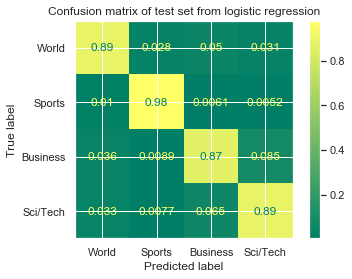

In [148]:
#plotting confusion matrix 
from sklearn.metrics import plot_confusion_matrix
sns.set_context('notebook')
class_names=list(classes.values())
disp = plot_confusion_matrix(baselogistic_classifier, X_test1, y_test,
                                 display_labels=class_names,
                                 cmap='summer',
                                 normalize='true')
print(disp.confusion_matrix)
disp.ax_.set_title('Confusion matrix of test set from logistic regression')

In [149]:
# chech the different between the logistic regression and the final CNN
p_value, deltas = bootstrap_sample(baselogistic_classifier_predictions_final, cnn_predictions_final.round().argmax(axis=1), y_dev)
print(p_value, p_value < 0.01)

0.0 True


The logistic regression ouperforms the optmized CNN

In [150]:
# check the difference between the dumb prediction and the logistic regression
p_value, deltas = bootstrap_sample(baselogistic_classifier_predictions, most_freq_predictions_test, y_dev)
print(p_value, p_value < 0.01)

0.0 True


In [151]:
# check the difference between the logistic regression and the cnn
p_value, deltas = bootstrap_sample(baselogistic_classifier_predictions, cnn_predictions_final.argmax(axis=1), y_dev)
print(p_value, p_value < 0.01)

0.0 True


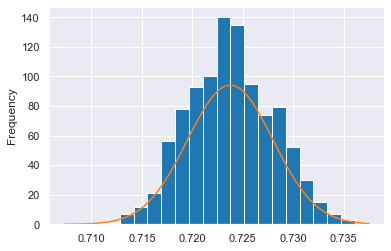

In [152]:
from scipy.stats import norm
pd.Series(deltas).plot.hist(bins=20)

#adding a gaussian curve 
mean,std=norm.fit(deltas)
xmin,xmax=plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y)